In [2]:
# Importing the necessary libraries for the project. 
import pandas as pd 
import yfinance as yf
import numpy as np # for numerical operations
import seaborn as sns #visualisation
import matplotlib.pyplot as plt # visualization
%matplotlib inline 
import matplotlib.ticker as ticker # Library to customize ticks
from datetime import date
import matplotlib.dates as mdates
from scipy import stats
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import MSTL # Multiple Seasonal decompose.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF and PACF plots.
from math import sqrt
from sklearn.model_selection import ParameterSampler
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
from statsmodels.stats.outliers_influence import variance_inflation_factor # Calculates Variance Inflation Factor to detect multicollinearity.
# ParameterSampler for randomized hyperparameter sampling, optimizing model parameters in cross-validation.
from sklearn.model_selection import ParameterSampler
# pmdarima's auto_arima for automated selection of the best ARIMA parameters based on AIC/BIC scores.
from pmdarima import auto_arima
# Mean Squared Error and Mean Absolute Error metrics from sklearn for evaluating model accuracy.
from sklearn.metrics import mean_squared_error, mean_absolute_error
# TimeSeriesSplit for cross-validation with time series data to preserve the temporal ordering of data.
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings # filter warnings
warnings.filterwarnings('ignore')

# Data Collection

<b>- When the dataset was imported with daily frequency it was observed high volatility, numerous outliers. And this characteristics might have impact when applying SARIMA(X) models. Thus, the same stock index will be imported, but with weekly frequency. 

<b>- Daily frequency also showed high-complex seasonality.

<b>- The aim of the new granularity is to reduce noise and volatility. In addition, increasing the frequency from business days (daily) to weekly will reduce the number of observations. Therefore, the range of weekly data collection will be from 2004 to 2023.

In [5]:
# Define ticker symbol and fetch weekly data
ticker_symbol = "^GSPC"
data = yf.download(ticker_symbol, start="2004-01-01", end="2023-12-31", interval="1wk")
display(data)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-01-01,1111.920044,1126.329956,1105.079956,1126.329956,1126.329956,5930800000
2004-01-08,1126.329956,1131.920044,1115.189941,1130.520020,1130.520020,8209800000
2004-01-15,1130.520020,1149.209961,1124.540039,1147.619995,1147.619995,6871900000
2004-01-22,1147.619995,1155.380005,1126.500000,1128.479980,1128.479980,8250600000
2004-01-29,1128.479980,1142.449951,1122.380005,1126.520020,1126.520020,8267800000
...,...,...,...,...,...,...
2023-11-30,4554.870117,4599.390137,4537.240234,4549.339844,4549.339844,22321960000
2023-12-07,4568.839844,4709.689941,4565.220215,4707.089844,4707.089844,20221130000
2023-12-14,4721.040039,4778.009766,4694.339844,4698.350098,4698.350098,26821650000


In [6]:
data.info() # displays types of columns and frame/set/series.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1044 entries, 2004-01-01 to 2023-12-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1044 non-null   float64
 1   High       1044 non-null   float64
 2   Low        1044 non-null   float64
 3   Close      1044 non-null   float64
 4   Adj Close  1044 non-null   float64
 5   Volume     1044 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 57.1 KB


# Data Preparation and EDA

- Only the Close column will be used in this project.

In [9]:
df = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1) # Drop columns.

In [10]:
# Get summary statistics
summary_stats = df.describe()

# Find the date of highest and lowest close price
peak_date = df.idxmax()  # Date of highest close price
lowest_date = df.idxmin()  # Date of lowest close price

# Output summary statistics and the highest and lowest close prices
print("Summary Statistics:\n", summary_stats)
print("Peak Close Price Date:", peak_date, "Value:", df.loc[peak_date])
print("Lowest Close Price Date:", lowest_date, "Value:", df.loc[lowest_date])

Summary Statistics:
              Close
count  1044.000000
mean   2142.159915
std    1088.574232
min     712.869995
25%    1267.787506
50%    1814.955017
75%    2800.122559
max    4793.060059
Peak Close Price Date: Close   2021-12-23
dtype: datetime64[ns] Value:                   Close
Date                   
2021-12-23  4793.060059
Lowest Close Price Date: Close   2009-02-26
dtype: datetime64[ns] Value:                  Close
Date                  
2009-02-26  712.869995


- The dataset has 1044 obseravtions
- The min (712.87), max (4793.06) with std of 1088.57, shows that the Close index vary substancially over time.  

In [12]:
# Check for missing values.
missing_values = df.isnull().sum()

# Print the number of missing values for each column.
print("Missing values:")
print(missing_values)

Missing values:
Close    0
dtype: int64


No missing value detected. 

In [14]:
# Check the frequency of the time series.
frequency = pd.infer_freq(df.index)

print("Frequency of the time series:", frequency) # Prints the frequency of the series.

Frequency of the time series: W-THU


- The series has weekly frequency, which was recorded every Thursday. 

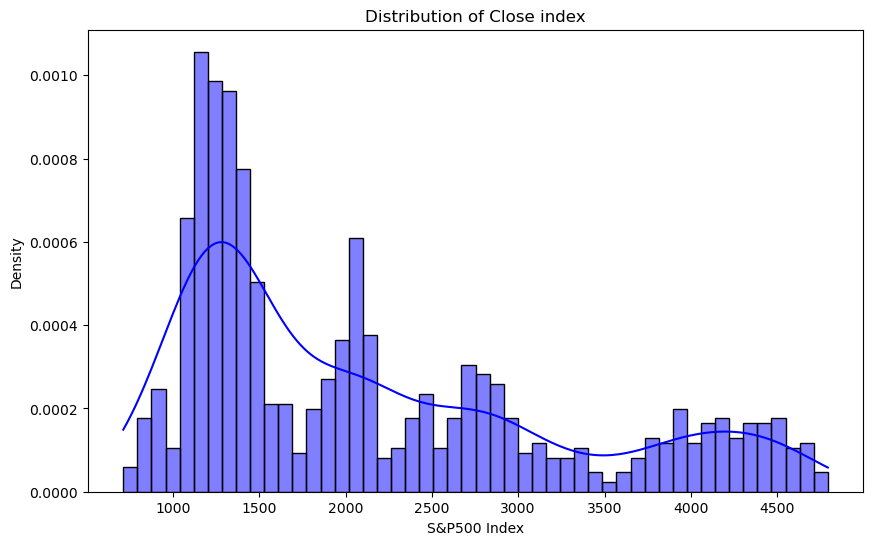

Shapiro-Wilk Test: Statistic=0.8695297241210938, p-value=1.2532030962952605e-28


In [86]:
from scipy.stats import shapiro

# Plot the histogram and density plot
plt.figure(figsize=(10, 6))
sns.histplot(df['Close'], kde=True, bins=50, color="blue", stat="density")
plt.title("Distribution of Close index")
plt.xlabel("S&P500 Index")
plt.ylabel("Density")
plt.show()

# Perform statistical tests for normality

# 1. Shapiro-Wilk Test
shapiro_stat, shapiro_p = shapiro(df['Close'])
print(f"Shapiro-Wilk Test: Statistic={shapiro_stat}, p-value={shapiro_p}")

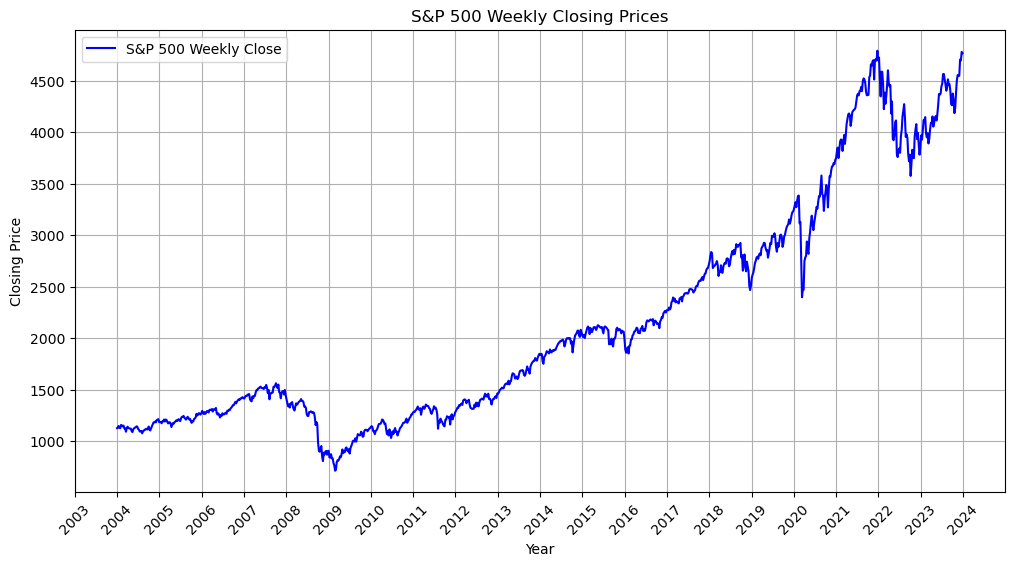

In [16]:
# Plot the time series with per-year labels
plt.figure(figsize=(12, 6))
plt.plot(df, label="S&P 500 Weekly Close", color='blue')

# Set title and labels
plt.title("S&P 500 Weekly Closing Prices")
plt.xlabel("Year")
plt.ylabel("Closing Price")

# Format x-axis to show every year
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Major ticks every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format labels as YYYY

# Rotate x-axis labels and add grid for clarity
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.show()

- Same as the daily frequency, the Index presents an upward trend, indicating a long-term growth.
- It is observable that during times of crisis such as in 2009 and 2019/20 (Covid), the market suffered.
- Strong indication of cyclical patterns.  

In [18]:
# Calculate z-scores for the closing prices
df['z_score'] = (df['Close'] - df['Close'].mean()) / df['Close'].std()

# Identify outliers where the absolute z-score is greater than 3
outliers = df[np.abs(df['z_score']) > 3]

# Display the outliers
print(outliers)

Empty DataFrame
Columns: [Close, z_score]
Index: []


- Using z-score greater than 3 or 2.5 no outliers were identified at this point. However, if more agressive value is attempted, such as 2, outlier will pop up, around 65. 

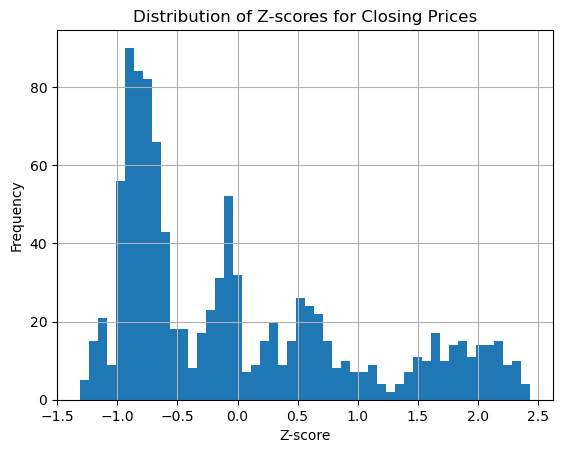

In [20]:
# Plot histogram of z-scores
df['z_score'].hist(bins=50)
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.title('Distribution of Z-scores for Closing Prices')
plt.show()

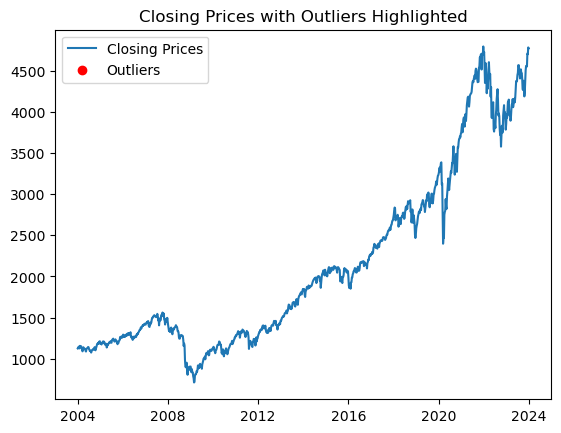

In [21]:
# Plot the closing prices and highlight the outliers
plt.plot(df['Close'], label='Closing Prices')
plt.scatter(outliers.index, outliers['Close'], color='red', label='Outliers', marker='o')
plt.legend()
plt.title('Closing Prices with Outliers Highlighted')
plt.show()

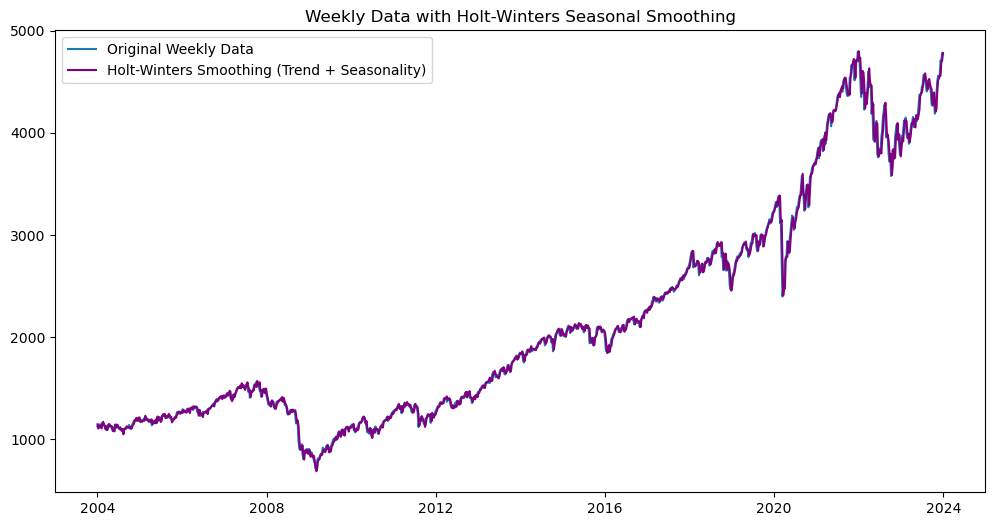

In [22]:
# Holt-Winters with weekly seasonality (assuming yearly cycle with 52-week seasonality)
hw_model = ExponentialSmoothing(df['Close'], trend='add', seasonal='add', seasonal_periods=52).fit()
hw_smoothed = hw_model.fittedvalues

# Plot the original data and the smoothed data
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Original Weekly Data')
plt.plot(hw_smoothed, color='purple', label='Holt-Winters Smoothing (Trend + Seasonality)')
plt.legend()
plt.title("Weekly Data with Holt-Winters Seasonal Smoothing")
plt.show()

<Figure size 1500x2000 with 0 Axes>

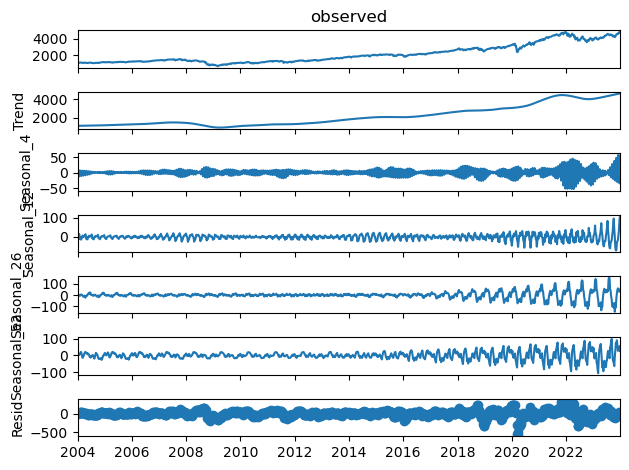

In [23]:
res = MSTL(df['Close'], periods=(4, 12, 26, 52)).fit()
plt.figure(figsize=(15, 20))
res.plot()
plt.tight_layout()
plt.show()

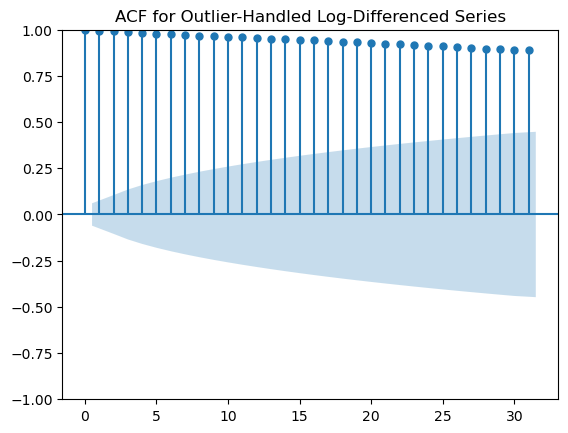

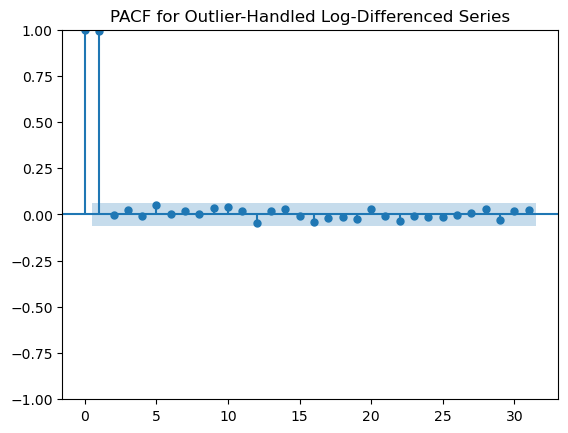

In [24]:
plot_acf(df['Close'])
plt.title("ACF for Outlier-Handled Log-Differenced Series")
plt.show()

plot_pacf(df['Close'])
plt.title("PACF for Outlier-Handled Log-Differenced Series")
plt.show()

The multiple seasonal decompose shows that:

**Trend**: It shows an upward trend for all different frequencies. 

**Seasonal Component**: 
- 4 Weeks: The period has the potential to capture monthly (short-term) changes in the market/stock. However, the plot shows that is very volatile and unstable.
- 12 Weeks: The period can be also represented by quaterly, showing patterns that occur every three months. And this is when the patterns are start to appear, which is still unstable. 
- 26 and 52 Weeks: Six months and One year respectivelly, they could capture long-term seasonality and trends. Their seasonality is smoother and with more clear patterns. 
    
**Residuals**: Also because of complex seasonality present, the residual plots shows variability, thus, there are still room for improvement, especially after 2019 (Covid).   

In addition, The ACF and PACF shows strong correlation with previous values. 

The baseline model for this project will be the SARIMA, a model that accounts for seasonality, auto-regressive, moving average and differencing in its portifolio. Therefore, the model might have the potential to capture the nuances of the stock index. 

To continue with the workflow, an assumption of the model has to be meet, which the series must be stationary. 

In [26]:
# Stationarity Test.
## ADF Test
result = adfuller(df['Close'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

### KPSS Test
result = kpss(df['Close'], regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 1.3387757928820059
p-value: 0.9968174599239991
Critial Values:
   1%, -3.4367085412302205
Critial Values:
   5%, -2.8643474145110512
Critial Values:
   10%, -2.568264786168072

KPSS Statistic: 4.596299
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


- Just differencing the series the p-value reduced substancially and it is way below 0.05.
- Statistical values are below the critical levels, for both ADF and KPSS.

Just applying first-order differencing,  the series will become stationary, an assumption met for auto-regressive models. However, it was observable that the series has high variance. Thus, a log transformation will also be performed to stabilize it. 

After applying winsorization it was observed that:
- Regarding the numnber of outliers, the approach had little impact.
- It capped the extreme values of the differenced series. The Min was -388 and now -185, the Max was 279 and now is 146.

The number of outlier according to the z-scores is way less compared to the total amount, thus they will remained in this format (represents "natural/financial" events. 

In [29]:
# Apply log transformation.
log = np.log(df['Close']) 

# First-order differencing to remove trend.
log_diff = log.diff().dropna()

In [30]:
log_diff.head() # display first five rows.

Date
2004-01-08    0.003713
2004-01-15    0.015013
2004-01-22   -0.016819
2004-01-29   -0.001738
2004-02-05    0.027354
Name: Close, dtype: float64

In [31]:
# Get summary statistics.
summary_stats = log_diff.describe()

# Find the date of highest and lowest close price.
peak_date = log_diff.idxmax()  # Date of highest close price.
lowest_date = log_diff.idxmin()  # Date of lowest close price.

# Output summary statistics and the highest and lowest close prices.
print("Summary Statistics:\n", summary_stats)
print("Peak Close Price Date:", peak_date, "Value:", log_diff.loc[peak_date])
print("Lowest Close Price Date:", lowest_date, "Value:", log_diff.loc[lowest_date])

Summary Statistics:
 count    1043.000000
mean        0.001384
std         0.022919
min        -0.164508
25%        -0.007633
50%         0.003626
75%         0.013568
max         0.107173
Name: Close, dtype: float64
Peak Close Price Date: 2020-04-02 00:00:00 Value: 0.10717307251876829
Lowest Close Price Date: 2008-10-02 00:00:00 Value: -0.16450798232492225


After making the series stationary, the statistical property now are:

- Count: Due to the first order diff, one row is lost. Thus, the new number of obervations is 1043.
- Min and Max: The transformations had major effects regaring the scale, before (712 - 4793) and now ranges from -0.16 to 0.10.
- Mean: Proportially with the new scale, the new mean is 0.001
- Std: The new value shows that the points vary 0.022. 
- Peak and Lowest record: The transformation also changed the highest and the lowest recorded point. The peak was on 23-12-21 and now is 02-04-2020 and the lowest was on 26-02-2009 and now is 02-10-2008.

After the transformation a stationary check will be called once again. 

In [33]:
# Stationarity Test.
## ADF Test
result = adfuller(log_diff, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

### KPSS Test
result = kpss(log_diff, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -32.78394873993528
p-value: 0.0
Critial Values:
   1%, -3.43664125006105
Critial Values:
   5%, -2.864317735333004
Critial Values:
   10%, -2.5682489786730818

KPSS Statistic: 0.141515
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


- All the values, pvalue and critical values indicates that the series is stationary.

Because of the transformations performed, a new search for outliers will be called. Despite not identified in previous stage (using zscore < 3), the same approach will be performed on the transformed data for further analysis. 

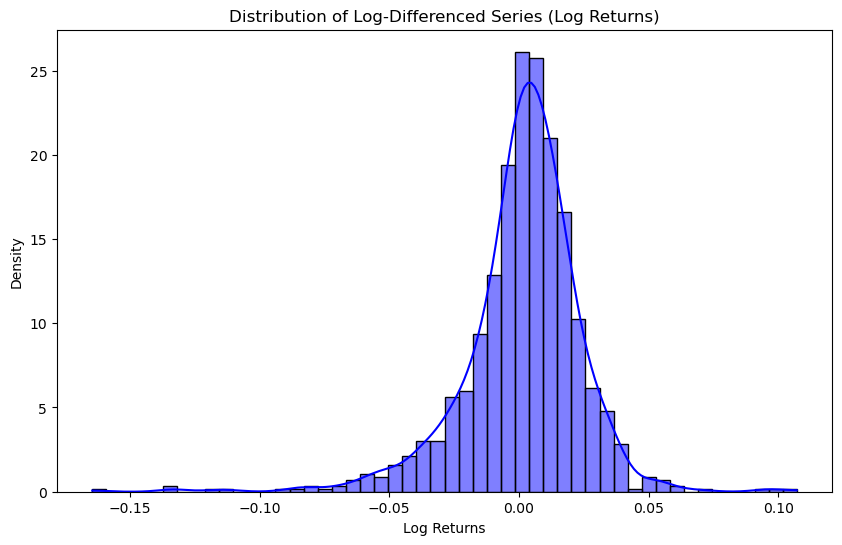

Shapiro-Wilk Test: Statistic=0.9063950777053833, p-value=8.793913715650803e-25


In [78]:
from scipy.stats import shapiro

# Plot the histogram and density plot
plt.figure(figsize=(10, 6))
sns.histplot(log_diff, kde=True, bins=50, color="blue", stat="density")
plt.title("Distribution of Log-Differenced Series (Log Returns)")
plt.xlabel("Log Returns")
plt.ylabel("Density")
plt.show()

# Perform statistical tests for normality

# 1. Shapiro-Wilk Test
shapiro_stat, shapiro_p = shapiro(log_diff)
print(f"Shapiro-Wilk Test: Statistic={shapiro_stat}, p-value={shapiro_p}")

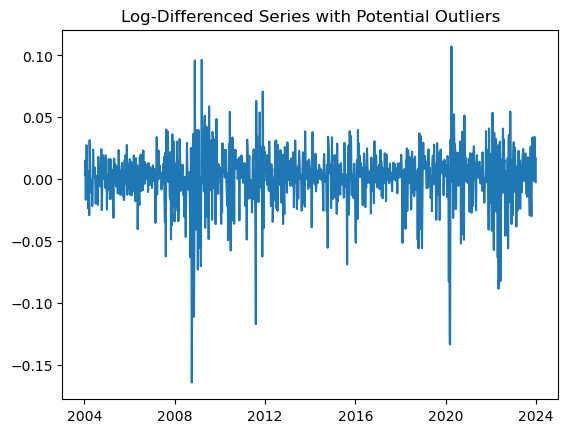

Date
2008-10-02   -0.164508
2008-10-09   -0.081513
2008-11-06   -0.111435
2008-11-20    0.095808
2009-01-08   -0.073240
2009-02-26   -0.070446
2009-03-12    0.096386
2011-08-04   -0.117374
2011-11-24    0.070747
2015-08-20   -0.069230
2020-02-20   -0.083018
2020-03-05   -0.132610
2020-03-12   -0.133785
2020-04-02    0.107173
2022-05-05   -0.088698
2022-06-09   -0.082463
Name: Close, dtype: float64


In [35]:
# Checking for outliers that could impact on SARIMA's performance. 
# Plot the transformed series.
plt.plot(log_diff)
plt.title('Log-Differenced Series with Potential Outliers')
plt.show()

# Z-score based outlier detection on transformed series.
z_scores = (log_diff - log_diff.mean()) / log_diff.std()
outliers = log_diff[np.abs(z_scores) > 3]
print(outliers)

Different techniques can be perfomed to handle outliers, but in this project the Winsorization techniques will be the chosen one:

- Despite being outliers, they are a valid record in time and by applying winsotization, the value is capped and not removed.
- The approach also is capable to maintain the structure of the data while handling outliers.

To apply the Winsorization, the values that are outside of the 1-99 percentile are going to be capped. 

In [37]:
# Calculate the 1st and 99th percentiles.
lower_limit = np.percentile(log_diff, 1)
upper_limit = np.percentile(log_diff, 99)

# Apply winsorization by clipping the values.
log_diff_winso = np.clip(log_diff, lower_limit, upper_limit)

# If you want to work with Pandas.
log_diff_winso = pd.Series(log_diff_winso)

In [38]:
# Get summary statistics
summary_stats = log_diff_winso.describe()

# Find the date of highest and lowest close price
peak_date = log_diff_winso.idxmax()  # Date of highest close price
lowest_date = log_diff_winso.idxmin()  # Date of lowest close price

# Output summary statistics and the highest and lowest close prices
print("Summary Statistics:\n", summary_stats)
print("Peak Close Price Date:", peak_date, "Value:", log_diff_winso.loc[peak_date])
print("Lowest Close Price Date:", lowest_date, "Value:", log_diff_winso.loc[lowest_date])

Summary Statistics:
 count    1043.000000
mean        0.001557
std         0.020693
min        -0.069935
25%        -0.007633
50%         0.003626
75%         0.013568
max         0.051947
Name: Close, dtype: float64
Peak Close Price Date: 2008-11-20 00:00:00 Value: 0.051946616718505895
Lowest Close Price Date: 2008-10-02 00:00:00 Value: -0.06993515131230828


After applying Winsorization, the statistical properties suffered small changes: 
- Min and Max: The extreme values were capped, thus reducing the maximum value from 0.107 to 0.052 and the minimum was -0.164 and now is -0.069.
- The mean and std had a slightly increase based on scale of the data. 

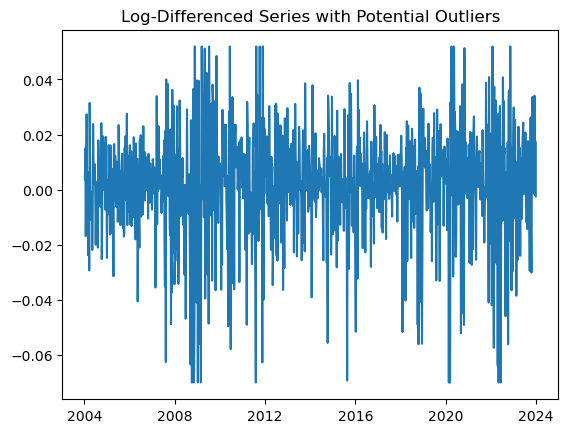

Date
2007-08-09   -0.062544
2008-09-11   -0.063368
2008-10-02   -0.069935
2008-10-09   -0.069935
2008-11-06   -0.069935
2009-01-08   -0.069935
2009-02-26   -0.069935
2011-08-04   -0.069935
2011-11-17   -0.062654
2015-08-20   -0.069230
2020-02-20   -0.069935
2020-03-05   -0.069935
2020-03-12   -0.069935
2022-04-21   -0.063767
2022-05-05   -0.069935
2022-06-09   -0.069935
Name: Close, dtype: float64


In [40]:
# Plot the transformed series.
plt.plot(log_diff_winso)
plt.title('Log-Differenced Series with Potential Outliers')
plt.show()

# Z-score based outlier detection on transformed series.
z_scores = (log_diff_winso - log_diff_winso.mean()) / log_diff_winso.std()
outliers1 = log_diff_winso[np.abs(z_scores) > 3]
print(outliers1)

- The Winsorization did not "remove" the outliers, because the extreme values were capped, the number of outliers remained the same, but the "location/date" changed.

After all the transformation the data might have new or persistent patterns and methods such as exponential smoothing can help to identify such trends and seasonality. However, within the available techniques Holt-Winters is a technique that will take into account both trend and seasonality, it will attempt to isolate these two components from the noise. The method is more robust in comparison with other approaches (like moving averages for example).

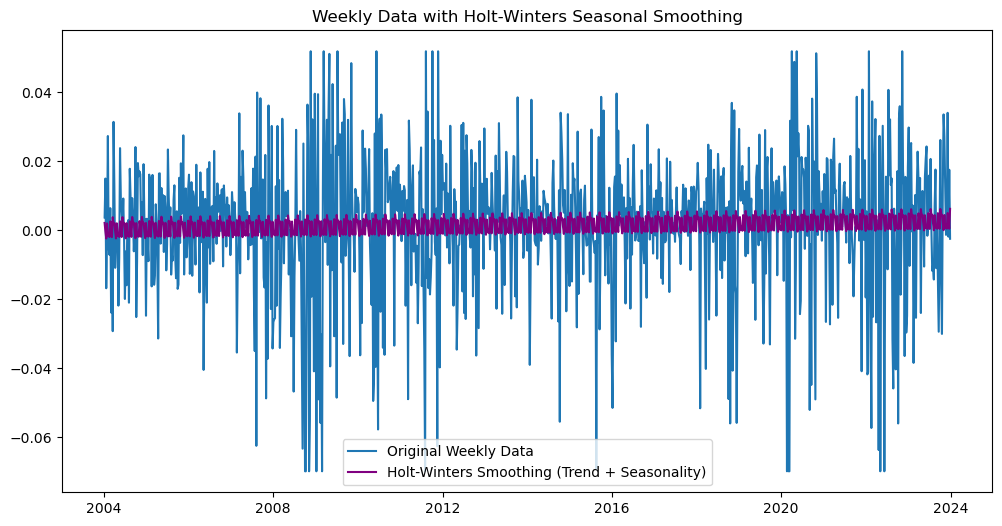

In [42]:
# Holt-Winters with weekly seasonality. 
hw_model = ExponentialSmoothing(log_diff_winso, trend='add', seasonal='add', seasonal_periods=12).fit()
hw_smoothed = hw_model.fittedvalues

# Plot the original data and the smoothed data.
plt.figure(figsize=(12, 6))
plt.plot(log_diff_winso, label='Original Weekly Data')
plt.plot(hw_smoothed, color='purple', label='Holt-Winters Smoothing (Trend + Seasonality)')
plt.legend()
plt.title("Weekly Data with Holt-Winters Seasonal Smoothing")
plt.show()

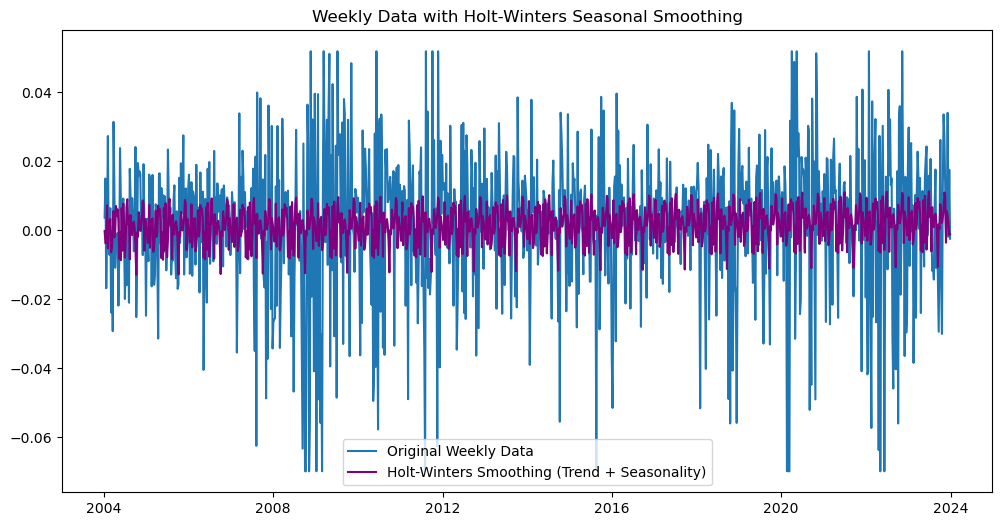

In [43]:
# Holt-Winters with weekly seasonality 
hw_model = ExponentialSmoothing(log_diff_winso, trend='add', seasonal='add', seasonal_periods=52).fit()
hw_smoothed = hw_model.fittedvalues

# Plot the original data and the smoothed data
plt.figure(figsize=(12, 6))
plt.plot(log_diff_winso, label='Original Weekly Data')
plt.plot(hw_smoothed, color='purple', label='Holt-Winters Smoothing (Trend + Seasonality)')
plt.legend()
plt.title("Weekly Data with Holt-Winters Seasonal Smoothing")
plt.show()

Applying the Holt-Winter Smoothing techniques with two different frequencies (quarterly and annualy) it is observable that: 

**Quaterly (12)**:
- Has a smoother line (less variability) than the Annual, meaning that quartely presents a better consitent seasonal pattern.

**Annual (52)**:
- It looks for long-term features, which can lead to miss information that are relevant for short-term features.  

Thus far, the analysis shows that the higher the frequency, the harder it gets to identify clear patterns (seasonality). In other words, the higher the frequency, higher the noise.   
Therefore, when applying models the frequency applied would 4 (One month) and 12 (Quaterly) they can yield better results by focusing on changes that occurs in short and mid-term scenario. 

In [45]:
# ADF Test
result = adfuller(log_diff_winso, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(log_diff_winso, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -34.250475779707344
p-value: 0.0
Critial Values:
   1%, -3.43664125006105
Critial Values:
   5%, -2.864317735333004
Critial Values:
   10%, -2.5682489786730818

KPSS Statistic: 0.201901
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


<Figure size 1500x2000 with 0 Axes>

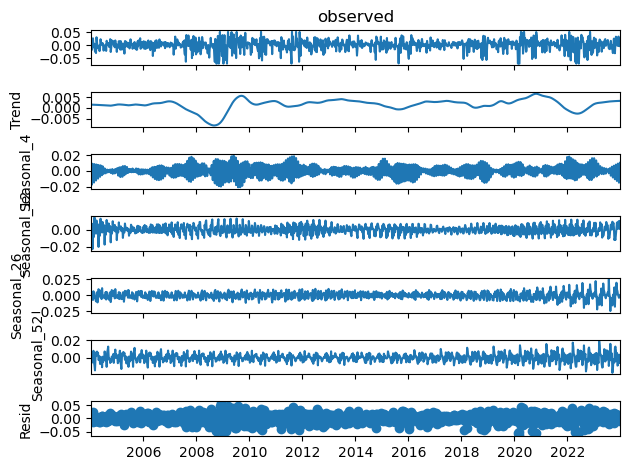

In [46]:
# Multiple seasonal decompose
res = MSTL(log_diff_winso, periods=(4, 12, 26, 52)).fit()
plt.figure(figsize=(15, 20))
res.plot()
plt.tight_layout()
plt.show()

The seasonal decompose shows that:

**Trend**: The figure shows the results after the transformation where the first order differencing remove the trend, now clustered around zero. 

**Seasonal Component**: 
- 4 Weeks: Even after the transformations, a short-term of 4 weeks the seasonality still looks unstable and noisy.
- 12 Weeks: It shows quartely patterns. 
- 26 Weeks: It illustrates six months, which is more consistent compared to lower periods and it may be a good option for seasonality in the model hyperparameter.  
- 52 Weeks: Same as the the 26, shows also more consistent patterns.

Thus, through the MSTL, the longer the period the better is for the models to capture seasonality of the data. 
    
**Residuals**: Also because of complex seasonality present, the residual plots shows variability, thus, there are still room for improvement, especially after 2019 (Covid).   

### Stationarity Check: ADF and KPSS Results
- ADF Test:

The ADF statistic is very low 
(−34.64) and lower than the critical values, in addition to the p-value of 0.0, which strongly indicates that. This confirms that the series is stationary after the transformations and outlier handling.

- KPSS Test:

The KPSS statistic is 0.201 which is below the critical values, but also with a p-value of around 0.1. Which indicates stationarity. 

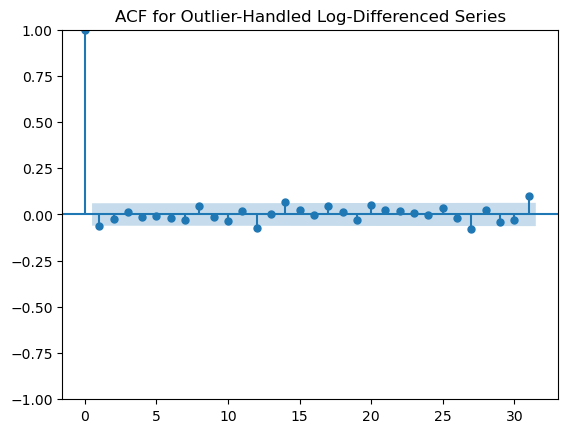

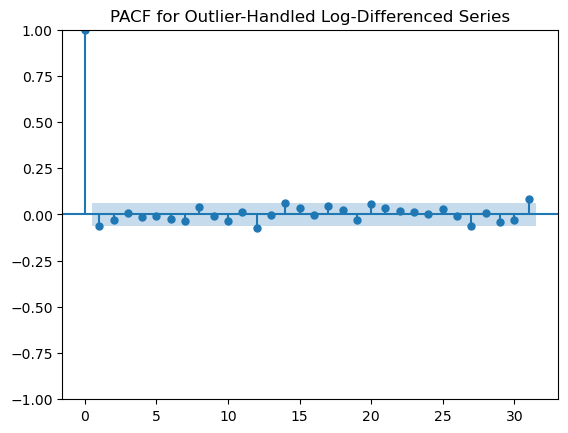

In [49]:
plot_acf(log_diff_winso.dropna())
plt.title("ACF for Outlier-Handled Log-Differenced Series")
plt.show()

plot_pacf(log_diff_winso.dropna())
plt.title("PACF for Outlier-Handled Log-Differenced Series")
plt.show()

### ACF/PACF Plot:

- The ACF plot shows a significant spike at lag 0 and quickly drops to near zero with no significant autocorrelation at subsequent lags. This suggests that there isn’t a strong moving average (MA) component in the series.
PACF Plot:

- Similar to the ACF plot, the PACF shows a large spike at lag 0 and quickly settles close to zero at other lags. This suggests that there isn’t a strong autoregressive (AR) component either.

After the transformation performed on the series, the seasonal decompose also suffered changes. 
**4 Weeks**: 
- Still shows a volatile series, in which has its challenges to identify seasonality in one month period.
- The residuals shows high volatility, indicating that leaves a lot of information in the residuals.
  
**12 Weeks**:
- By increasing the frequency to three months, the seasonal component started to capture repeating patterns.
- Residuals did not change much in comparison with 4 weeks, where noise is still present.

**26 and 52 Weeks**: 
- The seasonal component shows a more clear pattern that repeats every six months or annualy.
- Residuals, visually a mininal reduction in noise can be noticed.

To select frequency for modeling, the workflow will focus on short and mid term cylyes: 
- Can align with business/financial cycles, such as monthly and quaterly.
- Despite broader frequency (yearly) might have important characteristics, could potentially add unnecessary complexity and cause over or underfitting.

Thus, the frequency that are going to be tested for the baseline model is 4 (a month) and 12 (quarter). 

# Testing Baseline Model (SARIMA)

- The ratio for train and test for this Notebook is 85-15.

**Note**: Different ratios can be tested in this stage to check what ratio culd yield the best performance.

For this present project, the SARIMA model will be the baseline and this is due to features identified at this stage:
- Presence of trends.
- Presence of seasonality.
- Statistical model that has AR, MA, accounts for seasonality.

A well know model in forecasting techniques that will serve as baseline model that will try to capture the nuances of the series (trend and seasonality). 

In [62]:
# 85-15 train-test split
# Determine the split indices
train_size = int(0.85 * len(log_diff_winso))
test_size = int(0.15 * len(log_diff_winso))

# Create train, and test sets
train = log_diff_winso[:train_size]
test = log_diff_winso[train_size:]
print("Training set size:", len(train))
print("Test set size:", len(test))

Training set size: 886
Test set size: 157


The workflow of SARIMA will follow: 
1. Random parameter: Random values, starting point for hyper-parameter tunning.

2. Hyper-parameter tunning: Auto-arima and Random Search. The first will search through combinations that has the lower AIC value and the second will be performed along with cross validation techniques searching for the best RMSE.

3. Cross-Validation: Time-Series and Fixed Rolling Window.

4. Residuals: The analysis will be performed on the best model.   

**The evaluation of results and performance of each model will be at the end, when all models have being applied along with cross-validation techniques**. 

- Performing auto-arima to find optimal parameters using two different frequencies monthly and quaterly. The approach can be a starting point to generate optimal parameters, using the AIC to return the best orders.

**Note**: Rationales for hyperparameter tunning and cross-validation will be written in the present notebook only in order to avoid repetion.

### Six Months Frequency (m=26 weeks)

In [109]:
# Auto-ARIMA with seasonal component
auto_model = auto_arima(train, seasonal=True, m=26, 
                        max_p=3, max_d=1, max_q=3,   # Limits on (p, d, q)
                        max_P=2, max_D=1, max_Q=2,  # Limits on (P, D, Q)
                        stepwise=True,               # Uses a stepwise search
                        trace=True, random_state=42)                  # Display progress

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[26] intercept   : AIC=-4384.477, Time=4.79 sec
 ARIMA(0,0,0)(0,0,0)[26] intercept   : AIC=-4390.585, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[26] intercept   : AIC=-4390.083, Time=1.35 sec
 ARIMA(0,0,1)(0,0,1)[26] intercept   : AIC=-4390.218, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[26]             : AIC=-4387.577, Time=0.08 sec
 ARIMA(0,0,0)(1,0,0)[26] intercept   : AIC=-4388.646, Time=0.35 sec
 ARIMA(0,0,0)(0,0,1)[26] intercept   : AIC=-4388.607, Time=0.42 sec
 ARIMA(0,0,0)(1,0,1)[26] intercept   : AIC=-4386.952, Time=1.00 sec
 ARIMA(1,0,0)(0,0,0)[26] intercept   : AIC=-4391.949, Time=0.14 sec
 ARIMA(1,0,0)(0,0,1)[26] intercept   : AIC=-4390.062, Time=0.92 sec
 ARIMA(1,0,0)(1,0,1)[26] intercept   : AIC=-4388.401, Time=1.12 sec
 ARIMA(2,0,0)(0,0,0)[26] intercept   : AIC=-4390.264, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[26] intercept   : AIC=-4390.220, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[26] intercept   : AIC=-4392.061, Time=0.08 sec
 ARIM

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  886
Model:               SARIMAX(0, 0, 1)   Log Likelihood                2196.190
Date:                Thu, 07 Nov 2024   AIC                          -4388.380
Time:                        11:11:58   BIC                          -4378.807
Sample:                    01-08-2004   HQIC                         -4384.721
                         - 12-24-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0557      0.025     -2.244      0.025      -0.104      -0.007
sigma2         0.0004   1.48e-05     27.884      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.04   Jarque-

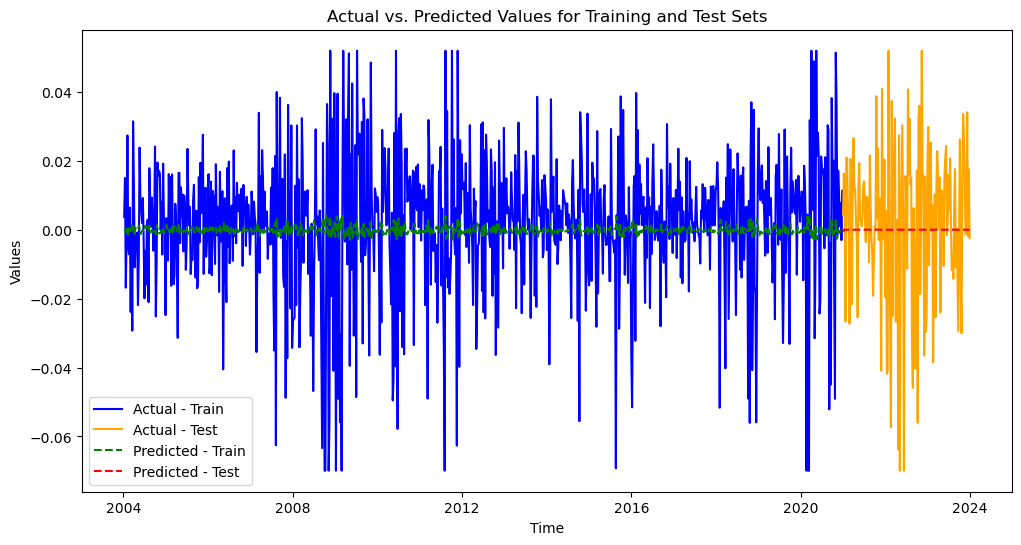

In [64]:
# Define SARIMAX model. 
sarimax_model = SARIMAX(train, order=(0, 0, 1), seasonal_order=(0, 0, 0, 26))
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test))
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

#### Random Search with Cross-Validation Technique.

- With different types of hyper-parameter tunning, the random search will be selected to to find the optimal parameters (30 different). The selection is due to the trade-off between range of values and computational resources (takes too long to run). In addition, a random state will be added to ensure reproducibility (same results).
- Grid Search was attempted but it was extremely computational expensive.
- Instead of applying the random search on a simple train and test fold, the approach will be performed along with cross validation (CV), providing a more reliable RMSE across differend folds. 

By performing CV on the parameters generated by the random search, it will also validate if the model performs well.

##### Time-Series Cross-Validation (TSCV) 



In [111]:
# Defines the train-test split indices for time-series cross-validation.
n_splits = 4
test_window = 50  # Number of rows for each test set.
initial_train_window = len(train) - n_splits * test_window

# Parameter grid and random sampling as defined in your prompt
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [26]
}

# Number of combinations to try.
n_iter_search = 30  # Number of random parameter combinations.
# Creates a list of the parameters tested and random_state is being called to reproduce same combinations. 
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42)) 

# Function to evaluate SARIMA with cross-validation.
def evaluate_sarima_cv_rmse(params): # Defining params (p,q,d) and seasonal (p,q,d,m).
    """
    Performs rolling cross-validation on SARIMA model with specified parameters and returns average RMSE.
    """
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rmse_scores = []  # Stores RMSE for each fold.
    
    for i in range(n_splits):
        # Defines the train and test indices for this fold.
        train_end = initial_train_window + i * test_window
        test_end = train_end + test_window
        
        y_train, y_test = train[:train_end], train[train_end:test_end]
        
        try:
            # Fit SARIMA model on the current training set.
            model = sm.tsa.statespace.SARIMAX(y_train,
                                              order=(p, d, q),
                                              seasonal_order=(P, D, Q, m),
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            result = model.fit(disp=False)

            # Forecast on the current test set (one-step ahead only).
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
            
            # Calculate RMSE for this fold.
            rmse = mean_squared_error(y_test, forecast, squared=False)
            rmse_scores.append(rmse)
        except Exception as e:
            print(f"Failed to fit model for parameters {params} on fold {i+1}: {e}")
            return np.inf  # Return large RMSE if fitting fails for this parameter set.
    
    # Calculate the average RMSE across all folds.
    avg_rmse = np.mean(rmse_scores)
    return avg_rmse

# Initialize variables to store the best parameters and lowest average RMSE.
best_rmse = np.inf
best_params = None

# Perform random search with cross-validation.
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}") # Prints the parameters tested.
    
    # Evaluate SARIMA model with cross-validation.
    rmse = evaluate_sarima_cv_rmse(params)
    
    # Track the best performing parameters and RMSE.
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

    print(f"Average RMSE across folds: {rmse}") # Prints the RMSE avg of each combinations.

# Output the best parameters and the best RMSE score.
print(f"Best parameters: {best_params}") # Returns the best combinations among the 30 attempts.
print(f"Best average RMSE across folds: {best_rmse}") # Returns the best avg RMSE among the 30 attempts.

Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 26, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}
Average RMSE across folds: 0.019691298804045538
Testing SARIMA parameters: {'q': 2, 'p': 1, 'm': 26, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}
Average RMSE across folds: 0.019463023639249406
Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 26, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}
Average RMSE across folds: 0.01973983474710419
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}
Average RMSE across folds: 0.02204437398618213
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
Average RMSE across folds: 0.024054866013207957
Testing SARIMA parameters: {'q': 0, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
Average RMSE across folds: 0.027040597389906273
Testing SARIMA parameters: {'q': 3, 'p': 0, 'm': 26, 'd': 0, 'Q': 2, 'P': 2, 'D': 0}
Average RMSE across folds: 0.019697369580238162
Testing SARIMA parameters: {'q': 1, 'p': 3, 'm': 26, 'd': 1, 'Q': 0, 'P

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  886
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 26)   Log Likelihood                2192.667
Date:                            Tue, 19 Nov 2024   AIC                          -4373.333
Time:                                    19:37:03   BIC                          -4344.620
Sample:                                01-08-2004   HQIC                         -4362.356
                                     - 12-24-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0645      0.025     -2.532      0.011      -0.114      -0.015
ar.L2         -0.0198      0.025   

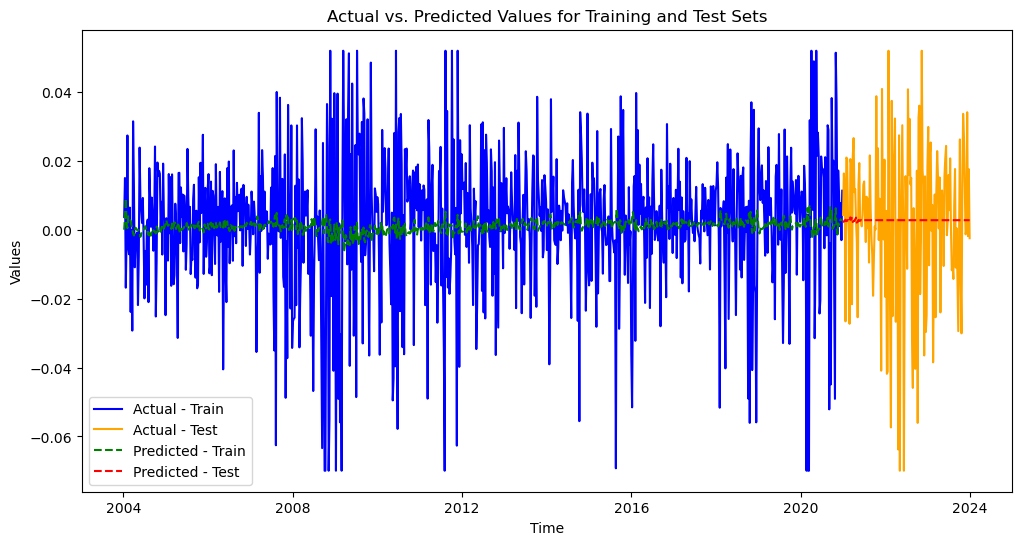

In [106]:
# Time-Series CV.
## Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(2, 1, 1), seasonal_order=(1, 0, 1, 26))
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test))
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

4 week (one month) Horizon RMSE: 0.023039289083161947
4 week (one month) Horizon MAE: 0.017526289443090447
4 week (one month) Horizon Directional Accuracy: 94.90%


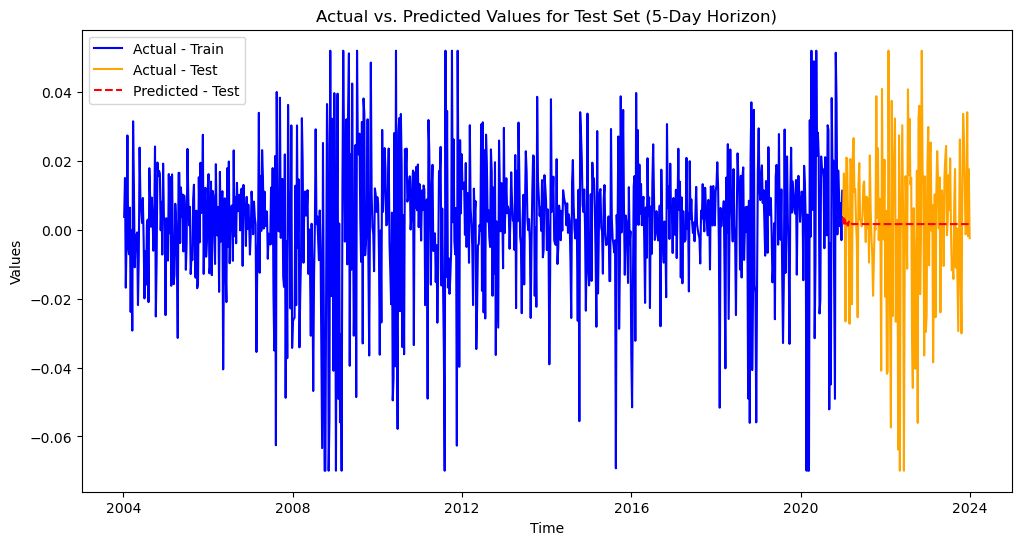

In [70]:
# Define a 4 week (one month) horizon for evaluation metrics.
horizon = 4

# Calculate RMSE over the 4 week (one month) horizon.
fours_weeks_rmse = np.sqrt(mean_squared_error(test[horizon:], test_predictions[:-horizon]))

# Calculate MAE over 4 week (one month) horizon.
fours_weeks_mae = mean_absolute_error(test[horizon:], test_predictions[:-horizon])

# Calculate 4 week (one month) Directional Accuracy.
direction_accuracy = np.mean(
    np.sign(test_predictions[:-horizon] - test_predictions[horizon:]) == 
    np.sign(test[:-horizon] - test[horizon:])
)

# Print evaluation metrics.
print("4 week (one month) Horizon RMSE:", fours_weeks_rmse)
print("4 week (one month) Horizon MAE:", fours_weeks_mae)
print(f"4 week (one month) Horizon Directional Accuracy: {direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on test set.
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Test Set (5-Day Horizon)")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [112]:
# Define parameter grid for SARIMA.
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [26]  # Seasonal period.
}

# Number of random parameter combinations to try
n_iter_search = 30  
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))

# Initialize to track the best parameters and lowest average RMSE.
best_rmse = np.inf
best_params = None

window_size = 300  # Fixed training window size.
test_size = 50  # Fixed test window size.

# Loop over each parameter combination in the random sample.
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}")
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rolling_rmses = []  # Store RMSE for each rolling window iteration.
    
    # Perform rolling window cross-validation
    for i in range(0, len(train) - window_size - test_size, test_size):
        y_train = train[i:i + window_size]
        y_test = train[i + window_size:i + window_size + test_size]
       
        try:
            # Fit SARIMA model on the current training set with sampled parameters.
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)

            # Forecast on the current test set (only one-step ahead).
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
            
            # Calculate RMSE for this fold.
            rmse = np.sqrt(mean_squared_error(y_test, forecast))
            rolling_rmses.append(rmse)
        except Exception as e:
            print(f"Failed to fit model on iteration {i} with parameters {params}: {e}")
            rolling_rmses.append(np.inf)  # Assign high error if fitting fails.
    
    # Calculate the average RMSE across all rolling windows for the current parameter set.
    avg_rolling_rmse = np.mean(rolling_rmses)
    print(f"Average Rolling Window RMSE for parameters {params}: {avg_rolling_rmse}")

    # Update best parameters if the current RMSE is lower
    if avg_rolling_rmse < best_rmse:
        best_rmse = avg_rolling_rmse
        best_params = params

# Output the best parameters and the best RMSE score
print(f"Best parameters: {best_params}") # Returns the best combinations among the 30 attempts.
print(f"Best average Rolling Window RMSE: {best_rmse}") # Returns the best avg RMSE among the 30 attempts.

Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 26, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 2, 'm': 26, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}: 0.01866927990774306
Testing SARIMA parameters: {'q': 2, 'p': 1, 'm': 26, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 1, 'm': 26, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}: 0.018517751494693067
Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 26, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 2, 'm': 26, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}: 0.01973657896739517
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}: 0.02290410559825239
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, '

                                       SARIMAX Results                                        
Dep. Variable:                                  Close   No. Observations:                  886
Model:             SARIMAX(2, 1, 1)x(2, 0, [1, 2], 4)   Log Likelihood                2192.269
Date:                                Thu, 07 Nov 2024   AIC                          -4368.539
Time:                                        11:17:23   BIC                          -4330.254
Sample:                                    01-08-2004   HQIC                         -4353.902
                                         - 12-24-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0910      0.027     -3.377      0.001      -0.144      -0.038
ar.

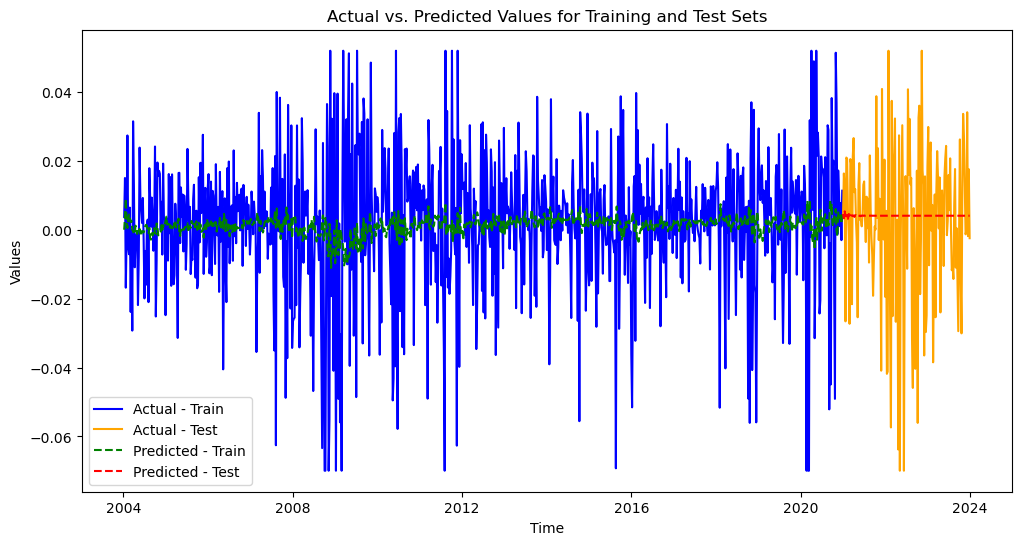

In [72]:
# Fixed Rolling window CV. 
## Define SARIMAX model 
sarimax_model = SARIMAX(train, order=(3, 1, 1), seasonal_order=(0, 0, 0, 26))
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test))
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

4 week (one month) Horizon RMSE: 0.023166443248265958
4 week (one month) Horizon MAE: 0.01742741853375015
4 week (one month) Horizon Directional Accuracy: 94.90%


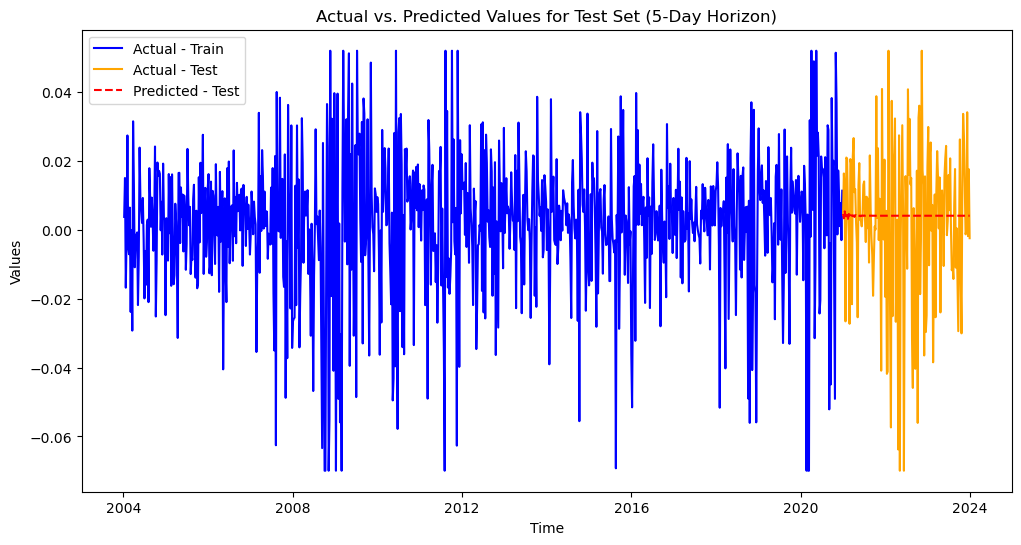

In [73]:
# Define a 4 week (one month) horizon for evaluation metrics.
horizon = 4

# Calculate RMSE over the 4 week (one month) horizon.
fours_weeks_rmse = np.sqrt(mean_squared_error(test[horizon:], test_predictions[:-horizon]))

# Calculate MAE over 4 week (one month) horizon.
fours_weeks_mae = mean_absolute_error(test[horizon:], test_predictions[:-horizon])

# Calculate 4 week (one month) Directional Accuracy.
direction_accuracy = np.mean(
    np.sign(test_predictions[:-horizon] - test_predictions[horizon:]) == 
    np.sign(test[:-horizon] - test[horizon:])
)

# Print evaluation metrics.
print("4 week (one month) Horizon RMSE:", fours_weeks_rmse)
print("4 week (one month) Horizon MAE:", fours_weeks_mae)
print(f"4 week (one month) Horizon Directional Accuracy: {direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on test set.
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Test Set (5-Day Horizon)")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

### Quaterly frequency (m=12) </b>

In [65]:
# Auto-ARIMA with seasonal component
auto_model = auto_arima(train, seasonal=True, m=12, 
                        max_p=3, max_d=1, max_q=3,   # Limits on (p, d, q)
                        max_P=2, max_D=1, max_Q=2,  # Limits on (P, D, Q)
                        stepwise=True, random_state=42,               # Uses a stepwise search
                        trace=True)                  # Display progress

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-4384.679, Time=2.82 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-4390.585, Time=0.22 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-4392.318, Time=1.41 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-4392.490, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-4387.577, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-4392.061, Time=0.32 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-4390.421, Time=0.67 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-4390.604, Time=2.83 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-4392.427, Time=1.04 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=-4388.603, Time=5.70 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-4390.998, Time=0.72 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-4390.598, Time=1.03 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=-4390.636, Time=0.84 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-4392.374, Time=0.89 sec
 ARIM

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  886
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 12)   Log Likelihood                2197.103
Date:                            Thu, 07 Nov 2024   AIC                          -4388.205
Time:                                    11:12:22   BIC                          -4373.845
Sample:                                01-08-2004   HQIC                         -4382.716
                                     - 12-24-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0557      0.025     -2.221      0.026      -0.105      -0.007
ma.S.L12      -0.0503      0.032   

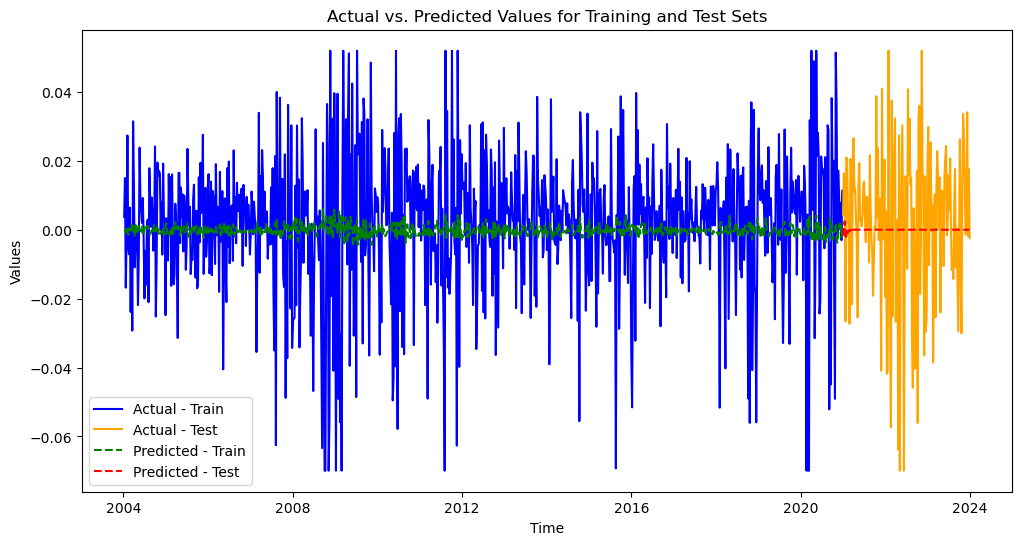

In [66]:
# Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(0, 0, 1), seasonal_order=(0, 0, 1, 12))
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test))
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [175]:
# Define the train-test split indices for time-series cross-validation.
n_splits = 4
test_window = 50  # Number of rows for each test set.
initial_train_window = len(train) - n_splits * test_window

# Parameter grid and random sampling as defined in your prompt.
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [12]
}

n_iter_search = 30  # Number of random parameter combinations.
# Creates a list of the parameters tested and random_state is being called to reproduce same combinations.
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))

# Function to evaluate SARIMA with cross-validation 
def evaluate_sarima_cv_rmse(params): # Defining params (p,q,d) and seasonal (p,q,d,m).
    """
    Performs rolling cross-validation on SARIMA model with specified parameters and returns average RMSE.
    """
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rmse_scores = []  # Store RMSE for each fold.
    
    for i in range(n_splits):
        # Define the train and test indices for this fold.
        train_end = initial_train_window + i * test_window
        test_end = train_end + test_window
        
        y_train, y_test = train[:train_end], train[train_end:test_end]
        
        try:
            # Fit SARIMA model on the current training set.
            model = sm.tsa.statespace.SARIMAX(y_train,
                                              order=(p, d, q),
                                              seasonal_order=(P, D, Q, m),
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            result = model.fit(disp=False)

            # Forecast on the current test set (one-step ahead only).
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
            
            # Calculate RMSE for this fold.
            rmse = mean_squared_error(y_test, forecast, squared=False)
            rmse_scores.append(rmse)
        except Exception as e:
            print(f"Failed to fit model for parameters {params} on fold {i+1}: {e}")
            return np.inf  # Return large RMSE if fitting fails for this parameter set.
    
    # Calculate the average RMSE across all folds.
    avg_rmse = np.mean(rmse_scores)
    return avg_rmse

# Initialize variables to store the best parameters and lowest average RMSE.
best_rmse = np.inf
best_params = None

# Perform random search with cross-validation.
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}") # Prints the parameters tested.
    
    # Evaluate SARIMA model with cross-validation.
    rmse = evaluate_sarima_cv_rmse(params)
    
    # Track the best performing parameters and RMSE.
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

    print(f"Average RMSE across folds: {rmse}") # Prints the RMSE avg of each combinations.

# Output the best parameters and the best RMSE score.
print(f"Best parameters: {best_params}") # Returns the best combinations among the 30 attempts.
print(f"Best average RMSE across folds: {best_rmse}") # Returns the best avg RMSE among the 30 attempts.

Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 12, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}
Average RMSE across folds: 0.019648665706746213
Testing SARIMA parameters: {'q': 2, 'p': 1, 'm': 12, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}
Average RMSE across folds: 0.01947011502742588
Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 12, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}
Average RMSE across folds: 0.019552015439171837
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 12, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}
Average RMSE across folds: 0.023072949019205417
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 12, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
Average RMSE across folds: 0.02416704121004686
Testing SARIMA parameters: {'q': 0, 'p': 0, 'm': 12, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
Average RMSE across folds: 0.03480139023647557
Testing SARIMA parameters: {'q': 3, 'p': 0, 'm': 12, 'd': 0, 'Q': 2, 'P': 2, 'D': 0}
Average RMSE across folds: 0.01966263567241423
Testing SARIMA parameters: {'q': 1, 'p': 3, 'm': 12, 'd': 1, 'Q': 0, 'P':

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                  886
Model:             SARIMAX(1, 1, 3)x(0, 0, [1], 12)   Log Likelihood                2193.945
Date:                              Thu, 07 Nov 2024   AIC                          -4375.890
Time:                                      11:29:14   BIC                          -4347.177
Sample:                                  01-08-2004   HQIC                         -4364.913
                                       - 12-24-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8994      0.750     -1.199      0.231      -2.370       0.571
ma.L1         -0.16

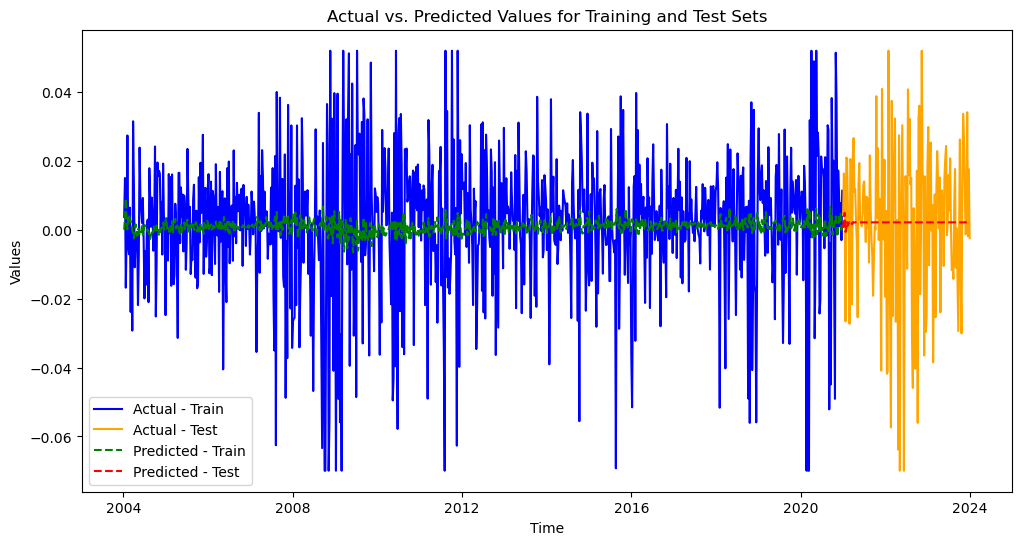

In [76]:
# Time-Series CV. 
## Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(1, 1, 3), seasonal_order=(0, 0, 1, 12))
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test))
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

4 week (one month) Horizon RMSE: 0.023041157888578183
4 week (one month) Horizon MAE: 0.017453997358438125
4 week (one month) Horizon Directional Accuracy: 94.90%


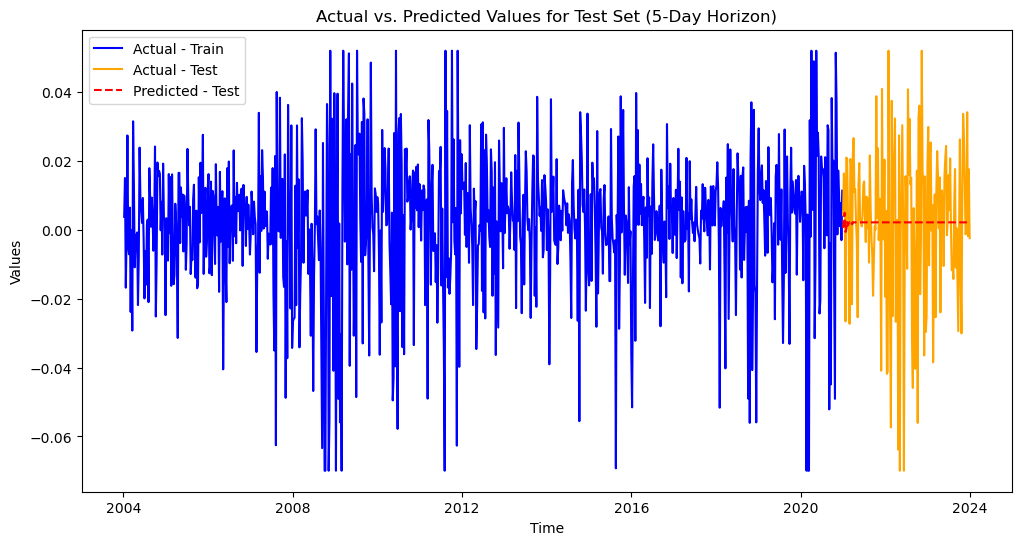

In [77]:
# Define a 4 week (one month) horizon for evaluation metrics.
horizon = 4

# Calculate RMSE over the 4 week (one month) horizon.
fours_weeks_rmse = np.sqrt(mean_squared_error(test[horizon:], test_predictions[:-horizon]))

# Calculate MAE over 4 week (one month) horizon.
fours_weeks_mae = mean_absolute_error(test[horizon:], test_predictions[:-horizon])

# Calculate 4 week (one month) Directional Accuracy.
direction_accuracy = np.mean(
    np.sign(test_predictions[:-horizon] - test_predictions[horizon:]) == 
    np.sign(test[:-horizon] - test[horizon:])
)

# Print evaluation metrics.
print("4 week (one month) Horizon RMSE:", fours_weeks_rmse)
print("4 week (one month) Horizon MAE:", fours_weeks_mae)
print(f"4 week (one month) Horizon Directional Accuracy: {direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on test set.
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Test Set (5-Day Horizon)")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [178]:
# Define parameter grid for SARIMA.
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [12]  # Seasonal period.
}

# Number of random parameter combinations to try
n_iter_search = 30  
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))

# Initialize to track the best parameters and lowest average RMSE.
best_rmse = np.inf
best_params = None

window_size = 300  # Fixed training window size.
test_size = 50  # Fixed test window size.

# Loop over each parameter combination in the random sample.
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}")
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rolling_rmses = []  # Store RMSE for each rolling window iteration.
    
    # Perform rolling window cross-validation
    for i in range(0, len(train) - window_size - test_size, test_size):
        y_train = train[i:i + window_size]
        y_test = train[i + window_size:i + window_size + test_size]
       
        try:
            # Fit SARIMA model on the current training set with sampled parameters.
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)

            # Forecast on the current test set (only one-step ahead).
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
            
            # Calculate RMSE for this fold.
            rmse = np.sqrt(mean_squared_error(y_test, forecast))
            rolling_rmses.append(rmse)
        except Exception as e:
            print(f"Failed to fit model on iteration {i} with parameters {params}: {e}")
            rolling_rmses.append(np.inf)  # Assign high error if fitting fails.
    
    # Calculate the average RMSE across all rolling windows for the current parameter set.
    avg_rolling_rmse = np.mean(rolling_rmses)
    print(f"Average Rolling Window RMSE for parameters {params}: {avg_rolling_rmse}")

    # Update best parameters if the current RMSE is lower
    if avg_rolling_rmse < best_rmse:
        best_rmse = avg_rolling_rmse
        best_params = params

# Output the best parameters and the best RMSE score
print(f"Best parameters: {best_params}") # Returns the best combinations among the 30 attempts.
print(f"Best average Rolling Window RMSE: {best_rmse}") # Returns the best avg RMSE among the 30 attempts.

Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 12, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 2, 'm': 12, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}: 0.018657693737930494
Testing SARIMA parameters: {'q': 2, 'p': 1, 'm': 12, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 1, 'm': 12, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}: 0.018495582704471967
Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 12, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 2, 'm': 12, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}: 0.019099464052917983
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 12, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 0, 'm': 12, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}: 0.0224901264572142
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 12, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 0, 'm': 12, 'd': 1, 'Q': 0, 

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                  886
Model:             SARIMAX(1, 1, 2)x(1, 0, [], 12)   Log Likelihood                2192.639
Date:                             Thu, 07 Nov 2024   AIC                          -4375.279
Time:                                     11:35:50   BIC                          -4351.351
Sample:                                 01-08-2004   HQIC                         -4366.131
                                      - 12-24-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9070      0.174     -5.201      0.000      -1.249      -0.565
ma.L1         -0.1048      

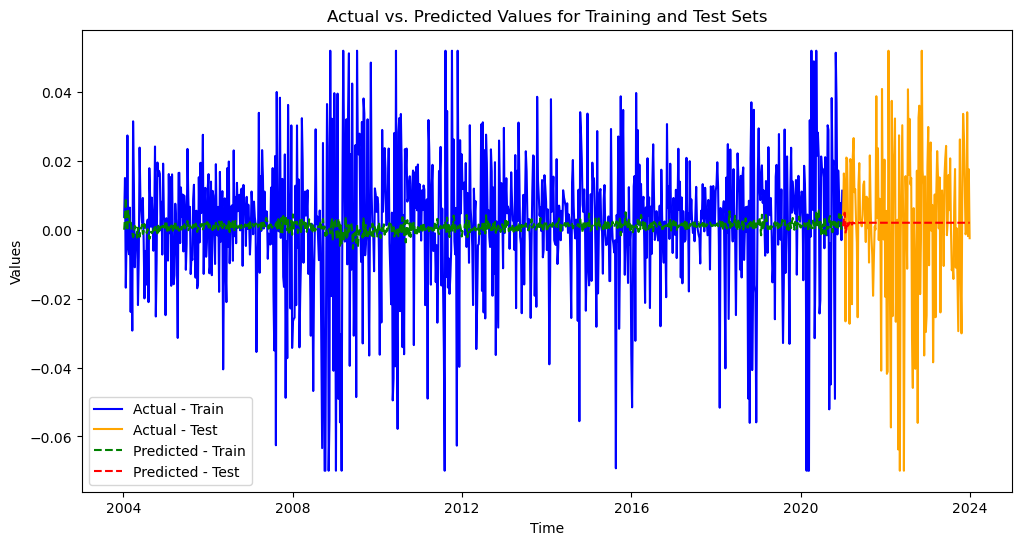

In [79]:
# Fixed Rolling window CV. 
## Define SARIMAX model. 
sarimax_model = SARIMAX(train, order=(1, 1, 2), seasonal_order=(1, 0, 0, 12))
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test))
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

4 week (one month) Horizon RMSE: 0.023032079498191686
4 week (one month) Horizon MAE: 0.01745409552543794
4 week (one month) Horizon Directional Accuracy: 94.90%


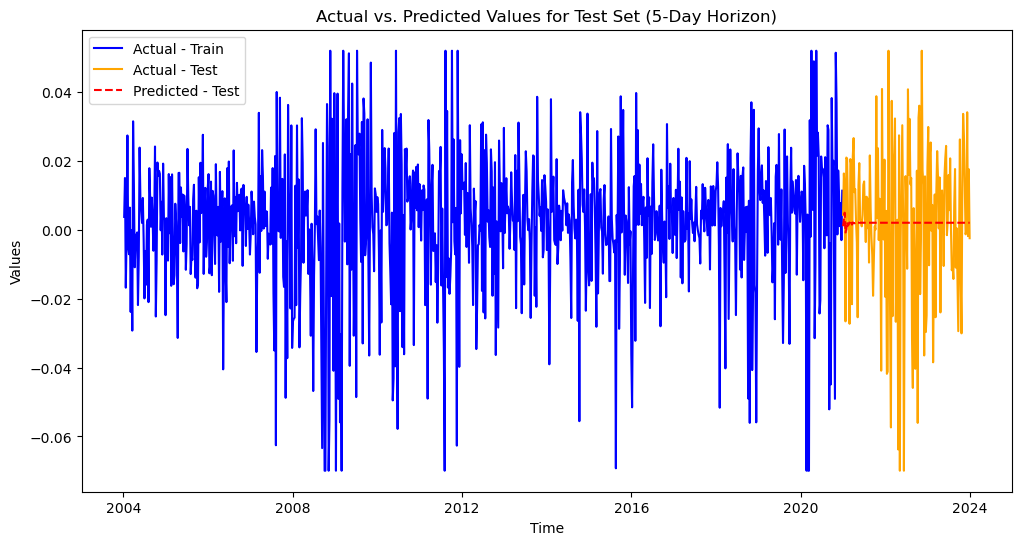

In [80]:
# Define a 4 week (one month) horizon for evaluation metrics
horizon = 4

# Calculate RMSE over the 4 week (one month) horizon
fours_weeks_rmse = np.sqrt(mean_squared_error(test[horizon:], test_predictions[:-horizon]))

# Calculate MAE over 4 week (one month) horizon
fours_weeks_mae = mean_absolute_error(test[horizon:], test_predictions[:-horizon])

# Calculate 4 week (one month) Directional Accuracy
direction_accuracy = np.mean(
    np.sign(test_predictions[:-horizon] - test_predictions[horizon:]) == 
    np.sign(test[:-horizon] - test[horizon:])
)

# Print evaluation metrics
print("4 week (one month) Horizon RMSE:", fours_weeks_rmse)
print("4 week (one month) Horizon MAE:", fours_weeks_mae)
print(f"4 week (one month) Horizon Directional Accuracy: {direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on test set
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot
plt.legend()
plt.title("Actual vs. Predicted Values for Test Set (5-Day Horizon)")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

### Annual (m=52)

In [94]:
# Auto-ARIMA with seasonal component
auto_model = auto_arima(train, seasonal=True, m=52, 
                        max_p=3, max_d=1, max_q=3,   # Limits on (p, d, q)
                        max_P=2, max_D=1, max_Q=2,  # Limits on (P, D, Q)
                        stepwise=True,               # Uses a stepwise search
                        trace=True, random_state=42)                  # Display progress

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=-4384.524, Time=111.90 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=-4390.585, Time=0.30 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=-4392.602, Time=111.16 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=-4392.900, Time=65.80 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=-4387.577, Time=0.79 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=-4392.061, Time=1.03 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=-4390.299, Time=51.43 sec
 ARIMA(0,0,1)(0,0,2)[52] intercept   : AIC=-4391.774, Time=263.80 sec
 ARIMA(0,0,1)(1,0,0)[52] intercept   : AIC=-4392.686, Time=14.91 sec
 ARIMA(0,0,1)(1,0,2)[52] intercept   : AIC=-4389.828, Time=326.40 sec
 ARIMA(0,0,0)(0,0,1)[52] intercept   : AIC=-4391.363, Time=7.68 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=-4391.000, Time=60.65 sec
 ARIMA(0,0,2)(0,0,1)[52] intercept   : AIC=-4391.011, Time=58.95 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=-4392.622, Time=4

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  886
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 52)   Log Likelihood                2197.281
Date:                            Thu, 21 Nov 2024   AIC                          -4388.563
Time:                                    20:10:00   BIC                          -4374.203
Sample:                                01-08-2004   HQIC                         -4383.073
                                     - 12-24-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0557      0.025     -2.232      0.026      -0.105      -0.007
ma.S.L52      -0.0461      0.034   

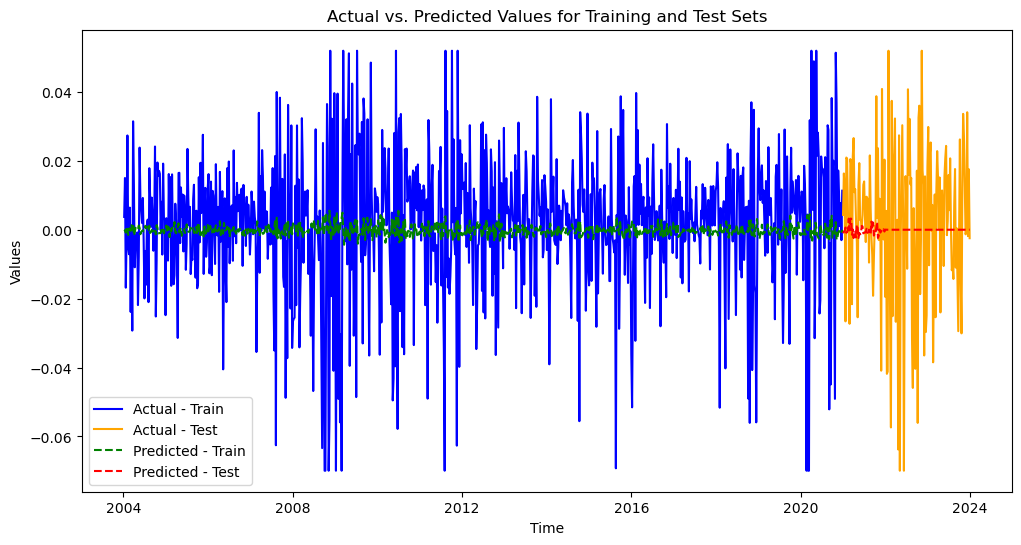

In [96]:
## Define SARIMAX model. 
sarimax_model = SARIMAX(train, order=(0, 0, 1), seasonal_order=(0, 0, 1, 52))
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test))
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [96]:
# Define parameter grid for SARIMA
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [52]  # Seasonal period
}

# Number of random parameter combinations to try
n_iter_search = 30
random_param_list = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Initialize variables to store the best parameters and lowest RMSE
best_rmse = np.inf
best_params = None

# Perform random search
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}")
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    try:
        # Fit SARIMA model on the training dataset
        model = sm.tsa.statespace.SARIMAX(
            train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, m),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        result = model.fit(disp=False)
        
        # Forecast on the test dataset
        forecast = result.predict(start=len(train), end=len(train) + len(test) - 1)
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(test, forecast))
        print(f"RMSE for parameters {params}: {rmse}")
        
        # Update best parameters if RMSE improves
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
    except Exception as e:
        print(f"Failed to fit model with parameters {params}: {e}")

# Output the best parameters and RMSE
print(f"Best parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 52, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}
RMSE for parameters {'q': 2, 'p': 2, 'm': 52, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}: 0.02309272643750862
Testing SARIMA parameters: {'q': 2, 'p': 1, 'm': 52, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}
RMSE for parameters {'q': 2, 'p': 1, 'm': 52, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}: 0.022983797830854417
Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 52, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}
RMSE for parameters {'q': 2, 'p': 2, 'm': 52, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}: 0.022572231972369974
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 52, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}
RMSE for parameters {'q': 2, 'p': 0, 'm': 52, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}: 0.02578002396664388
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 52, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
RMSE for parameters {'q': 2, 'p': 0, 'm': 52, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}: 0.027367331765809088
Testing SARIMA parameters: {'q': 0, 'p': 0, 'm': 52, 'd': 1, 'Q': 0, 'P': 1, 

- TSCV

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                  886
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 52)   Log Likelihood                1987.568
Date:                              Tue, 19 Nov 2024   AIC                          -3963.136
Time:                                      18:52:10   BIC                          -3934.786
Sample:                                  01-08-2004   HQIC                         -3952.266
                                       - 12-24-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0523      0.123     -8.555      0.000      -1.293      -0.811
ar.L2         -0.05

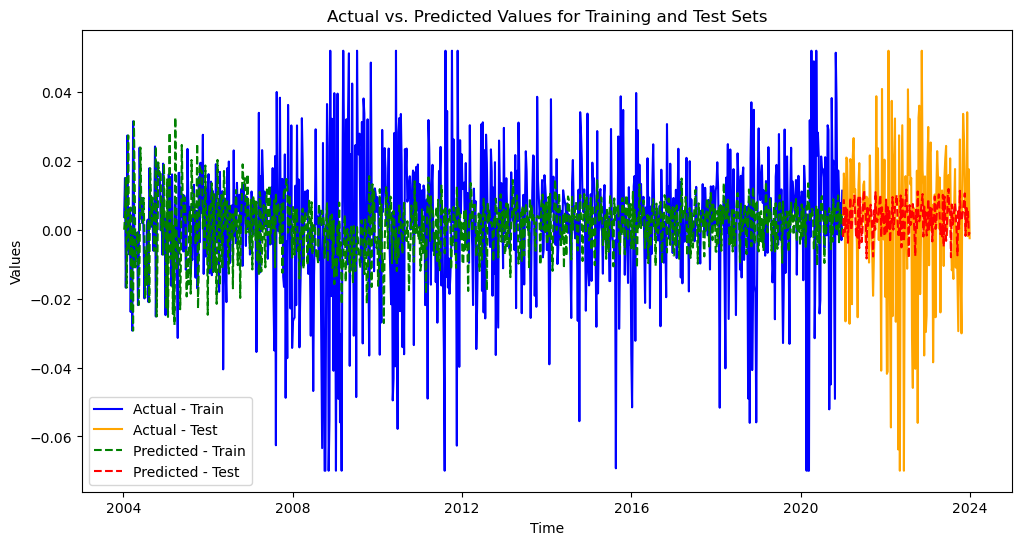

In [102]:
## Define SARIMAX model. 
sarimax_model = SARIMAX(train, order=(2, 1, 2), seasonal_order=(0, 1, 1, 52))
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test))
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [100]:
# Optimal parameters from random search
optimal_params = {
    'p': 2,   
    'd': 1,   
    'q': 2,  
    'P': 0,   
    'D': 1,   
    'Q': 1,   
    'm': 52   # (seasonal period)
}
p, d, q = optimal_params['p'], optimal_params['d'], optimal_params['q']
P, D, Q, m = optimal_params['P'], optimal_params['D'], optimal_params['Q'], optimal_params['m']

# TSCV Setup
n_splits = 4
test_window = 50
initial_train_window = len(train) - n_splits * test_window

# Function to evaluate SARIMA with TSCV
def tscv_evaluate_sarima(params):
    """
    Perform TSCV on SARIMA with given parameters and return average RMSE.
    """
    rmse_scores = []
    
    for i in range(n_splits):
        # Define train and test indices for each fold
        train_end = initial_train_window + i * test_window
        test_end = train_end + test_window
        y_train, y_test = train[:train_end], train[train_end:test_end]
 
        
        try:
            # Fit SARIMA model
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)
            
            # Forecast on the test set
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
            
            # Calculate RMSE
            rmse = mean_squared_error(y_test, forecast, squared=False)
            rmse_scores.append(rmse)
        except Exception as e:
            print(f"Failed on fold {i+1}: {e}")
            return np.inf  # Assign high error if model fails
    
    # Return the average RMSE across all folds
    avg_rmse = np.mean(rmse_scores)
    return avg_rmse

# Run TSCV evaluation
tscv_rmse = tscv_evaluate_sarima(optimal_params)
print(f"TSCV Average RMSE: {tscv_rmse}")

TSCV Average RMSE: 0.02007949956158871


- Fixed Rolling Window CV

In [101]:
# Fixed Rolling Window Setup
window_size = 300  # Training window size
test_size = 50     # Test window size

# Function to evaluate SARIMA with fixed rolling window
def fixed_rolling_evaluate_sarima(params):
    """
    Perform Fixed Rolling Window evaluation on SARIMA with given parameters and return average RMSE.
    """
    rolling_rmses = []
    
    for i in range(0, len(train) - window_size - test_size, test_size):
        y_train = train[i:i + window_size]
        y_test = train[i + window_size:i + window_size + test_size]
        
        try:
            # Fit SARIMA model
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)
            
            # Forecast on the test set
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
            
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(y_test, forecast))
            rolling_rmses.append(rmse)
        except Exception as e:
            print(f"Failed on rolling window iteration {i+1}: {e}")
            rolling_rmses.append(np.inf)
    
    # Return the average RMSE across all rolling windows
    avg_rmse = np.mean(rolling_rmses)
    return avg_rmse

# Run Fixed Rolling Window evaluation
fixed_rolling_rmse = fixed_rolling_evaluate_sarima(optimal_params)
print(f"Fixed Rolling Window Average RMSE: {fixed_rolling_rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Fixed Rolling Window Average RMSE: 0.02103357786305931


### Model Performance: Auto-Arima vs. Random Search & Cross-Validation (CV)

---

### Seasonality = 12
| Metric         | Auto-Arima    | Random Search  | CV (m=12)          |
|-----------------|---------------|----------------|--------------------|
| **Train RMSE** | 0.02026734    | 0.020249108    | **TSCV**: 0.019470115 |
| **Test RMSE**  | 0.022957145   | 0.022889601    | **RFWCV**: 0.018495583 |
| **Train MAE**  | 0.014947076   | 0.014789010    |                    |
| **Test MAE**   | 0.017675724   | 0.01737091     |                    |
| **Train DA**   | 99%           | 99%            |                    |
| **Test DA**    | 98%           | 98%            |                    |

---

### Seasonality = 26
| Metric         | Auto-Arima    | Random Search  | CV (m=26)          |
|-----------------|---------------|----------------|--------------------|
| **Train RMSE** | 0.020288313   | 0.020279357    | **TSCV**: 0.019451954 |
| **Test RMSE**  | 0.02297406    | 0.022933509    | **RFWCV**: 0.018609515 |
| **Train MAE**  | 0.014940298   | 0.014806998    |                    |
| **Test MAE**   | 0.017693545   | 0.017339234    |                    |
| **Train DA**   | 99%           | 99%            |                    |
| **Test DA**    | 98%           | 98%            |                    |

---

### Seasonality = 52
| Metric         | Auto-Arima    | Random Search  | CV (m=52)          |
|-----------------|---------------|----------------|--------------------|
| **Train RMSE** | 0.020262706  | 0.022030956    | **TSCV**: 0.0200795 |
| **Test RMSE**  | 0.023034086  | 0.022563222    | **RFWCV**: 0.021033578 |
| **Train MAE**  | 0.014928436  | 0.01660765     |                    |
| **Test MAE**   | 0.017820885  | 0.017065952    |                    |
| **Train DA**   | 99%           | 99%            |                    |
| **Test DA**    | 98%           | 98%            |                    |

---

### **Observations**
1. **Lowest CV RMSE**:
   - **m=12** (RFWCV = 0.018495583) achieves the lowest cross-validation RMSE overall.
   - This indicates strong validation performance for seasonality = 12.

2. **Generalization (Test RMSE and Test MAE)**:
   - **m=12 Random Search** achieves the lowest Test RMSE (0.022889601) and Test MAE (0.01737091), indicating strong generalization.

3. **Consistency Across Metrics**:
   - **m=26 Random Search** shows balanced performance across Train RMSE, Test RMSE, and CV RMSE.
   - **m=52 Random Search** performs well on Train and Test RMSE but has higher CV RMSE compared to m=12 and m=26.

---

### **Best Performer:**
- The technology that outperfomed was the one using seasonality of 52 weeks (quartely), not only has one of the lowest test RMSE, but in general it has a more balanced metrics of all the different frequencies. Also, the CV's scores are closer to the test RMSE. 

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                  886
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 52)   Log Likelihood                1987.568
Date:                              Thu, 21 Nov 2024   AIC                          -3963.136
Time:                                      20:19:58   BIC                          -3934.786
Sample:                                  01-08-2004   HQIC                         -3952.266
                                       - 12-24-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0523      0.123     -8.555      0.000      -1.293      -0.811
ar.L2         -0.05

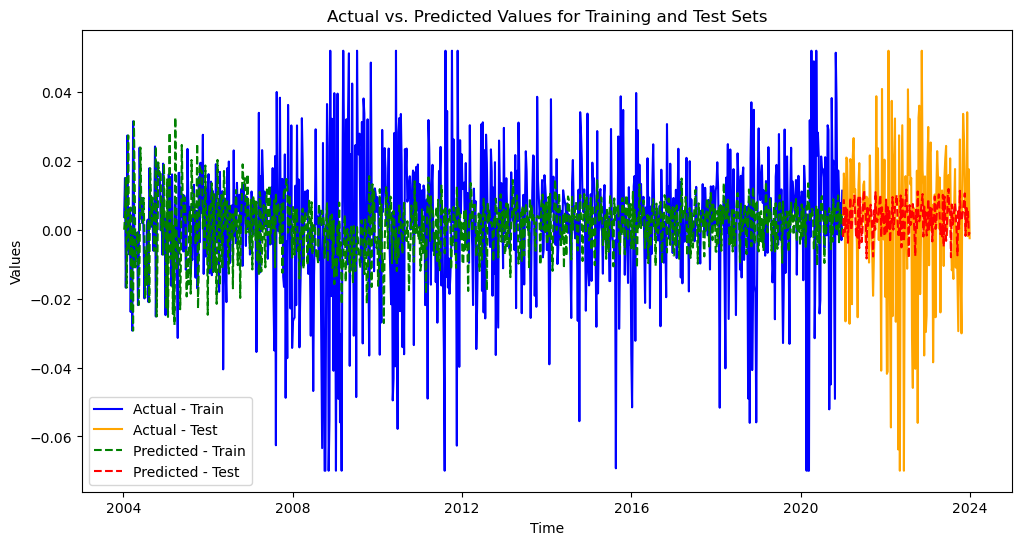

In [99]:
# Define SARIMAX model. 
sarimax_model = SARIMAX(train, order=(2, 1, 2), seasonal_order=(0, 1, 1, 52))
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test))
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

- Analysis of residuals will be performed on the best model. 

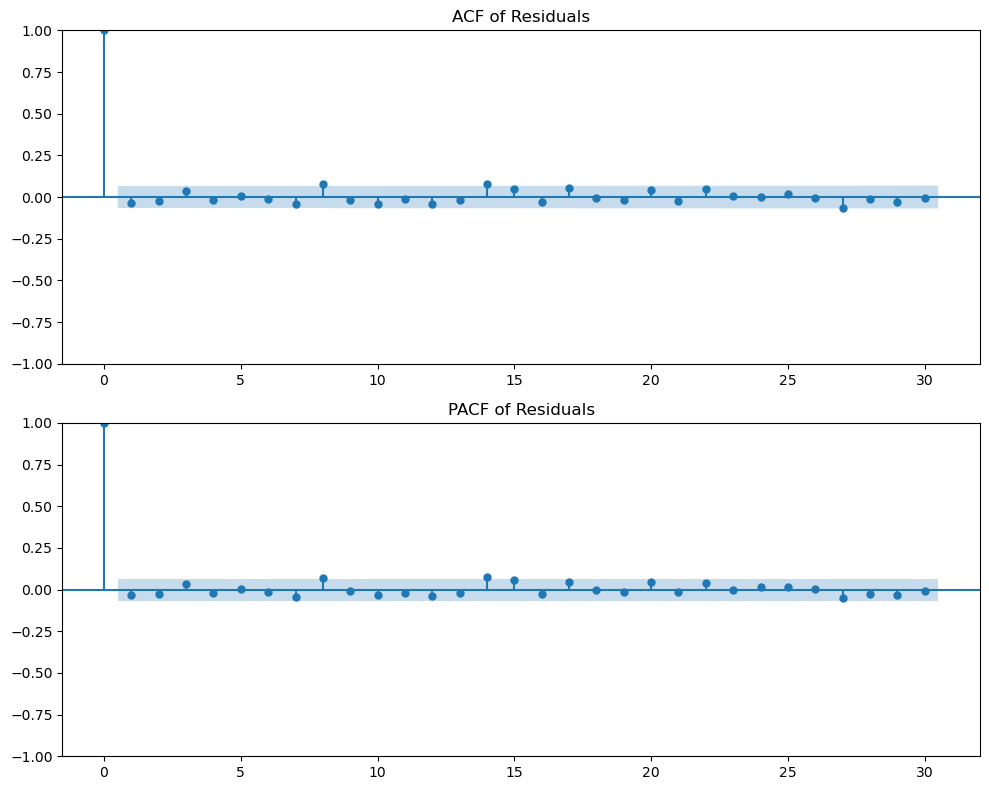

In [100]:
# Calculate residuals from the fitted model.
residuals = sarimax_final_fitted.resid

# Plot ACF and PACF for residuals.
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
sm.graphics.tsa.plot_acf(residuals, lags=30, ax=ax[0])
ax[0].set_title('ACF of Residuals')
sm.graphics.tsa.plot_pacf(residuals, lags=30, ax=ax[1])
ax[1].set_title('PACF of Residuals')
plt.tight_layout()
plt.show()

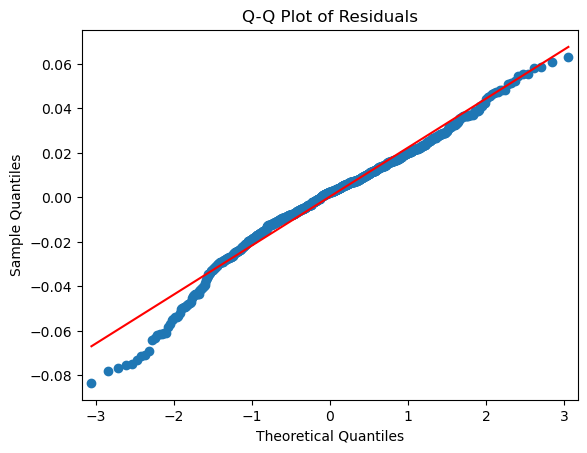

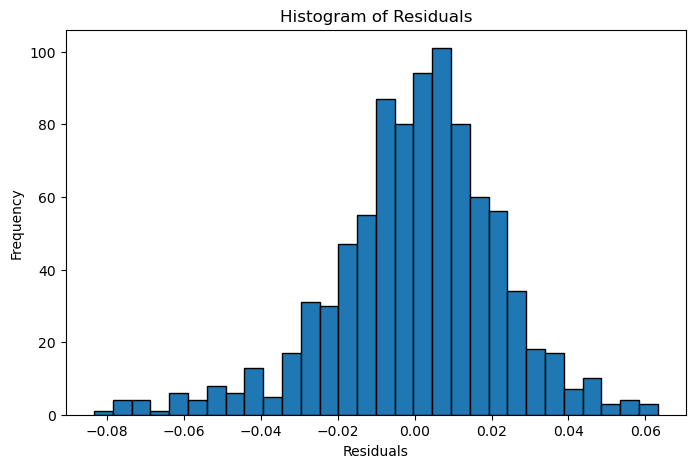

In [101]:
# Q-Q plot for normality check.
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Histogram of residuals.
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

According to the ACF/PACF plot:
- The majority of the values falls under the confidence of inteval, suggesting that the model capture most of the autocorrelation in the series.

The Q-Q plot and Histogram: 
- The values apparently follows a normal distribution, however deviations are present especially in the tails. The histogram also confirms the information, almost at a bell shape with a heavy skewness.
- The deviations at the tails suggests that the model is struggling to capture nuances of extreme values (i.e.: economic crisis, market crash).

The model in general is capturing the nuances of the data (variance, trend), however is not being able to capture sudden changes or extreme values. And numerous optoins are avalible that might improve the model performance. And to improve the baseline model, exogenous variables will performed to help the model with the issues identified at this stage. 

# Feature Engineering 

- Transforming the series to a frame to perform feature engineering.

**The goal of extracting endogenous features and use as exogenous features is to improve accuracy of the model**.
- Best performers of each workflow (notebook) will be compare and ultimately the decision of if the features helped or not the model.
- The metrics that are going to judge is the RMSE and MAE, DA is only secondary.  

In [82]:
df1 = log_diff_winso.copy() # Creates a copy 
df1 = pd.DataFrame(df1)  # Convert the Series to a DataFrame
df1.head()

,Close
Date,
2004-01-08,0.003713
2004-01-15,0.015013
2004-01-22,-0.016819
2004-01-29,-0.001738
2004-02-05,0.027354


- The S&P 500 index suffered transformations since imported from the yfinance library and the extraction of features (exogenous variables) will take the transformations into account. 

- The lagged features and rolling statistics extracted (short and medium term), aiming to help the model with volatility and short-term dependencies. 

In [83]:
# Adding lagged features.
df1['lag_1'] = df1['Close'].shift(1) # one week.
df1['lag_2'] = df1['Close'].shift(2) # two weeks.
df1['lag_4'] = df1['Close'].shift(4) # one month.

# Rolling mean and standard deviation.
df1['rolling_mean_4w'] = df1['Close'].rolling(window=4).mean() # One month. 
df1['rolling_mean_12w'] = df1['Close'].rolling(window=12).mean() # Three months.
df1['rolling_std_4w'] = df1['Close'].rolling(window=4).std() # One month. 
df1['rolling_std_12w'] = df1['Close'].rolling(window=12).std() # Three months.

# Rolling volatility (standard deviation of returns).
df1['volatility_4w'] = df1['Close'].pct_change().rolling(window=4).std() # One month.
df1['volatility_12w'] = df1['Close'].pct_change().rolling(window=12).std() # Three months.

df1.dropna(inplace=True)

In [84]:
# Check for missing values.
missing_values = df1.isnull().sum()

# Print the number of missing values for each column.
print("Missing values:")
print(missing_values)

Missing values:
Close               0
lag_1               0
lag_2               0
lag_4               0
rolling_mean_4w     0
rolling_mean_12w    0
rolling_std_4w      0
rolling_std_12w     0
volatility_4w       0
volatility_12w      0
dtype: int64


In [85]:
df1.describe()

,Close,lag_1,lag_2,lag_4,rolling_mean_4w,rolling_mean_12w,rolling_std_4w,rolling_std_12w,volatility_4w,volatility_12w
count,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000
mean,0.001575,0.001608,0.001563,0.001508,0.001578,0.001516,0.017813,0.019022,7.731465,10.888745
std,0.020723,0.020744,0.020760,0.020750,0.009796,0.005364,0.011330,0.008708,23.505939,22.440608
min,-0.069935,-0.069935,-0.069935,-0.069935,-0.051352,-0.026288,0.001353,0.004492,0.154122,1.039283
25%,-0.007633,-0.007633,-0.007795,-0.007858,-0.003032,-0.001013,0.009401,0.012643,1.538535,2.688501
50%,0.003635,0.003666,0.003635,0.003626,0.002937,0.002346,0.015074,0.017074,2.585030,5.433938
75%,0.013568,0.013643,0.013568,0.013514,0.007596,0.004979,0.023516,0.024267,6.157669,10.194631
max,0.051947,0.051947,0.051947,0.051947,0.031089,0.019145,0.059466,0.045908,338.128664,195.854751


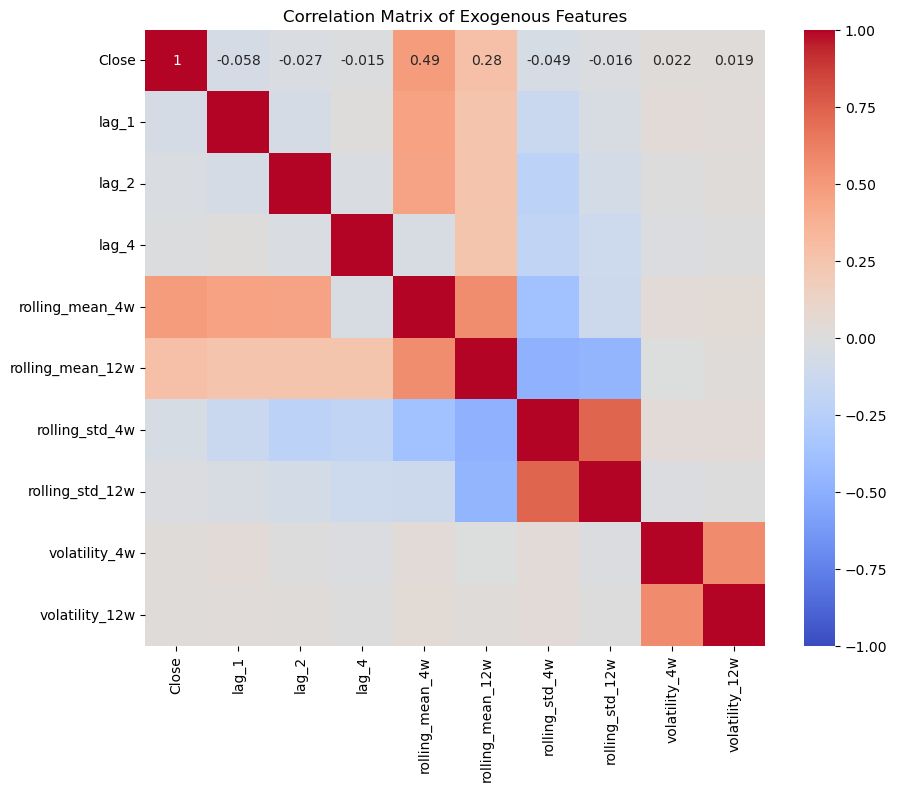

Close               1.000000
lag_1              -0.057565
lag_2              -0.026915
lag_4              -0.014659
rolling_mean_4w     0.491269
rolling_mean_12w    0.280976
rolling_std_4w     -0.049147
rolling_std_12w    -0.016258
volatility_4w       0.022095
volatility_12w      0.018503
Name: Close, dtype: float64


In [86]:
# Calculate the correlation matrix
correlation_matrix = df1[['Close', 'lag_1', 'lag_2', 'lag_4', 'rolling_mean_4w', 'rolling_mean_12w', 'rolling_std_4w', 
                          'rolling_std_12w', 'volatility_4w', 'volatility_12w']].corr()

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Exogenous Features')
plt.show()

# Display only the target's correlation with the other features
print(correlation_matrix['Close'])

The correlation matrix of the features indicates that:
- Rolling mean (4,12) have the highest correlation positive scores, which can aid the model by capturing patters that the model by itself cannot.
- Lagged features have low correlation with the target, but to aid with sudden changes the features might be helpful.
- Rolling statistics and volatility also presents lower values of correlation.    

In [87]:
# Create a DataFrame for features only
features = df1[['Close', 'lag_1', 'lag_2', 'lag_4', 'rolling_mean_4w', 'rolling_mean_12w', 'rolling_std_4w', 
                'rolling_std_12w', 'volatility_4w', 'volatility_12w']]
# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = features.columns
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print(vif)

            Feature        VIF
0             Close   2.164980
1             lag_1   2.015755
2             lag_2   1.912680
3             lag_4   1.199030
4   rolling_mean_4w   5.070892
5  rolling_mean_12w   1.719953
6    rolling_std_4w  10.350254
7   rolling_std_12w  10.174914
8     volatility_4w   1.631639
9    volatility_12w   1.803380


The selection of features will be performed using the correlation matrix along with the VIF scores (for multicolinearity): 
- Lagged Features: Despite the ACF/PACF of residuals shows that most of autocorrelation values falls under the shaded area, adding values of previous week and month might help the model to converge a bit better.
- Rolling mean is selected for its potential to assess momentum, trends and looking at short-term (one month) and mid-term (three months).
- Volatility: Feature to help with short-term risk or urcentainty. 

In [88]:
# Function to perform ADF and KPSS tests
def check_stationarity(df1, feature_name):
    # Augmented Dickey-Fuller test
    adf_result = adfuller(df1.dropna())  # Drop NaN for the test
    adf_p_value = adf_result[1]  # p-value from ADF test
    
    # KPSS test
    kpss_result = kpss(df1.dropna(), regression='c')  # 'c' for constant (level stationarity)
    kpss_p_value = kpss_result[1]  # p-value from KPSS test
    
    # Print results
    print(f"Feature: {feature_name}")
    print(f"  ADF Test p-value: {adf_p_value} - {'Stationary' if adf_p_value < 0.05 else 'Non-Stationary'}")
    print(f"  KPSS Test p-value: {kpss_p_value} - {'Stationary' if kpss_p_value > 0.05 else 'Non-Stationary'}\n")

# List of all features to check (assuming they are in a DataFrame `df`)
feature_names = ['Close', 'lag_1', 'lag_4', 'rolling_mean_4w', 'rolling_mean_12w']

# Check stationarity for each feature
for feature in feature_names:
    check_stationarity(df1[feature], feature)

Feature: Close
  ADF Test p-value: 0.0 - Stationary
  KPSS Test p-value: 0.1 - Stationary

Feature: lag_1
  ADF Test p-value: 0.0 - Stationary
  KPSS Test p-value: 0.1 - Stationary

Feature: lag_4
  ADF Test p-value: 0.0 - Stationary
  KPSS Test p-value: 0.1 - Stationary

Feature: rolling_mean_4w
  ADF Test p-value: 7.414673184071668e-06 - Stationary
  KPSS Test p-value: 0.1 - Stationary

Feature: rolling_mean_12w
  ADF Test p-value: 5.434436824016459e-07 - Stationary
  KPSS Test p-value: 0.1 - Stationary



In [89]:
df1.head()

,Close,lag_1,lag_2,lag_4,rolling_mean_4w,rolling_mean_12w,rolling_std_4w,rolling_std_12w,volatility_4w,volatility_12w
Date,,,,,,,,,,
2004-04-01,0.012635,0.031461,-0.029274,-0.023861,0.003674,0.000735,0.025511,0.018942,117.596902,68.441683
2004-04-08,-0.010896,0.012635,0.031461,-0.000125,0.000981,-0.001424,0.026591,0.018641,117.741650,68.548361
2004-04-15,-0.003623,-0.010896,0.012635,-0.029274,0.007394,-0.000325,0.018820,0.018029,0.776477,68.513236
2004-04-22,-0.001496,-0.003623,-0.010896,0.031461,-0.000845,-0.000305,0.009847,0.018028,0.623353,68.505990
2004-04-29,-0.000784,-0.001496,-0.003623,0.012635,-0.004200,-0.002649,0.004624,0.015795,0.647610,67.938276


In [90]:
df1 = df1[['Close', 'lag_1', 'lag_4', 'rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w']].copy()

- The dataset will be saved so the work can be continue in a different notebook. The option is focusing on organization and with a lighter Jupyter. 

In [91]:
# Saving dataframe to the Desktop to initiate trials with new features. 
df1.to_csv('C:/Users/nozom/OneDrive/Desktop/New folder/df1.csv', index=True)